# Generic Nearest Neighborhood Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
path_save_data = '/Users/jwhickey/Nolan Lab Dropbox/John Hickey/CRUK/Cell_Atlas/analysis/'
df = pd.read_csv(path_save_data+'22_08_09_CellAtlas_only_Processed_Metadata.csv', index_col=0)
save_path = '/Users/jwhickey/Nolan Lab Dropbox/John Hickey/CRUK/Cell_Atlas/analysis/Cell_Neigh_percent/'
df.columns

Index(['CHGA', 'MMP9', 'CD36', 'CK7', 'PDL1', 'Bcatenin', 'Vimentin', 'FoxP3',
       'CD56', 'CD31', 'pH2AX', 'CD90', 'CD15', 'PD1', 'aSMA', 'CD25', 'Ki67',
       'Cytokeratin', 'CD20', 'CD4', 'CD11c', 'AnnexA1', 'Nestin', 'p53',
       'CD73', 'EGFR', 'MUC5AC', 'HLADR', 'COX2', 'BCL2', 'p63', 'CD3', 'MUC2',
       'CD8', 'CD45', 'PGA3', 'CD57', 'CD68', 'aDef5', 'CD34', 'Podoplanin',
       'CD38', 'CD11b', 'CD163', 'MUC1', 'CD138', 'Arginase1', 'PP', 'CD79a',
       'MUC6', 'region', 'x', 'y', 'sample', 'region_num', 'CD206', 'CollIV',
       'unique_region', 'Accession_number', 'Block_ID', 'Sample_type',
       'neigh_name', 'neigh_sub', 'community', 'community common', 'Cell Type',
       'Core Type', 'Accession number', 'Sample', 'Block type',
       'Initial block diagnosis', '% invasive', '%dysplasia',
       '%metaplasia+columnar', '% normal squam mucosa', '% HG dyspalsia',
       '% LG dysplasia', '% Glandular', '% metaplasia', 'consensus diagnosis',
       'Sub diagnosis', '

# Load Functions

In [3]:
pal_temp = {

  'Productive T cell & Tumor': sns.color_palette('bright')[0], 
'Immune Cells': sns.color_palette('bright')[9],
 'Unproductive T Cell Tumor Interface': sns.color_palette('bright')[3],
 'Neutrophils & Tumor': sns.color_palette('bright')[8],
 'Immunosuppressive Endothelial': sns.color_palette('bright')[4],
 'NK cell': sns.color_palette('bright')[1],

 'Ki67+ Tumor': sns.color_palette('bright')[2],
 'Tumor': sns.color_palette('bright')[7],
 'Vasculature': sns.color_palette('bright')[6],
 'Immunosuppressive Antigen Presenting Cells': sns.color_palette('bright')[5],

     
    'a':'dodgerblue',
    'b':'lightskyblue',
    'c':'plum',
    'd':'orange',
    'e':'mediumpurple',
    'f':'thistle',
    'g':'lightgreen',
    'h':'green',
    'i':'gold',
    'j':'yellow',
    'k':'gray',
    'l':'brown',
    
    
   'CD4+ T cell':'yellowgreen',
   'CK7+ Epithelial cell':'tan',
   'Neck cell':'navy',
  'Neuroendocrine cell':'bisque',   
 'Chief cell':'goldenrod',
  'Goblet cell':'blueviolet',
  'Foveolar cell':'darkorange',   
 'Stromal cell':'teal',
 'PDPN+ Stromal cell':'olive',
 'p63+ EGFR+ Epithelial cell':'dimgray',
 'Gastric mucouse secreting cell':'indigo',
 'Biglycan+ Stromal cell':'lightcoral',
 'Dendritic cell':'cyan',
 'Paneth cell':'ivory',
 'B cell':'beige',
 'Squamous Epithelial cell':'darkblue',
 'Immune unknown cell':'lightcyan',
 'p63+ Epithelial cell':'royalblue',

  'Nerve cell':'magenta',
     'CD8+ T cell':'black',
  'Neutrophil':'skyblue',
 'Parietal cell':'fuchsia',
    
    
}

pal_temp2 = {    'd':'orange',
    'e':'mediumpurple',
    'f':'thistle',
    'g':'lightgreen',
    'h':'green',
    'i':'gold',
    'j':'yellow',
    'k':'gray',
    'l':'brown',
    
    
   'CD4+ T cell':'yellowgreen',
   'CK7+ Epithelial cell':'tan',
   'Neck cell':'navy',
  'Neuroendocrine cell':'bisque',   
 'Chief cell':'goldenrod',
  'Goblet cell':'blueviolet',
  'Foveolar cell':'darkorange',   
 'Stromal cell':'teal',
 'PDPN+ Stromal cell':'olive',
 'p63+ EGFR+ Epithelial cell':'dimgray',
 'Gastric mucouse secreting cell':'indigo',
 'Biglycan+ Stromal cell':'lightcoral',
 'Dendritic cell':'cyan',
 'Paneth cell':'ivory',
 'B cell':'beige',
 'Squamous Epithelial cell':'darkblue',
 'Immune unknown cell':'lightcyan',
 'p63+ Epithelial cell':'royalblue',

  'Nerve cell':'magenta',
     'CD8+ T cell':'black',
  'Neutrophil':'skyblue',
 'Parietal cell':'fuchsia',
    
    
}

In [4]:
def get_adata(data, list_keep_obs=None, index_nam = 'tissue_index'):
    
    if list_keep_obs is None:
        list_keep_obs = ['first_index', 'x', 'y', 'tissue', 'donor', 'region', 'OLFM4', 'FAP',
       'CD25', 'CollIV', 'CK7', 'Xcorr', 'Ycorr', 'unique_region',
       'neigh_name', 'neigh_sub1', 'Preservation_method', 'Tissue_location',
       'array', 'Cell Type', 'Cell Type em', 'Cell subtype', 'machine',
       'MUC6', index_nam]
    data.reset_index(inplace=True)
    data.rename(columns={'index':index_nam}, inplace=True)
    
    #Prepare for making into anndata format so that obs and data are separate
    data_sc = data.drop(columns = list_keep_obs) #USER INPUT

    #Convert to anndata format
    adata = sc.AnnData(data_sc)
    adata.obs = data[list_keep_obs]
    m_list = adata.var.index.to_list()
    
    return adata, m_list


def adata_to_dataframe(adata):
    df_var = adata.to_df()
    df_obs = adata.obs
    df = pd.concat([df_var,df_obs], axis=1)
    return df


def sc_heat(data, cell_type, cell_col, vmax=5):
    data_subset = data[data.obs[cell_col] == cell_type]
    sc.pl.heatmap(data_subset, var_names=data.var_names, vmax=vmax, figsize=(20,10), show_gene_labels=True)
    
    
def swarm_box(data, grouping, replicate, sub_col, sub_list, per_cat, norm=True,\
              figure_sizing=(10,5), save_name=None, h_order=None, col_in=None, \
              pal_color=None, flip=False):
       
    #Find Percentage of cell type
    test= data.copy()
    sub_list1 = sub_list.copy()
    
    if norm==True:
        test1 = test.loc[test[sub_col].isin(sub_list1)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=test.copy()
        immune_list = list(test.loc[test[sub_col].isin(sub_list1)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate])
    test_freq1 = test_freq[immune_list]

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate,])#,value_vars=immune_list)
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    if col_in:
        melt_per_plot = melt_per_plot.loc[melt_per_plot[per_cat].isin(col_in)]
    else:
        melt_per_plot = melt_per_plot
    
    #Order by average
    plot_order = melt_per_plot.groupby(per_cat).mean().reset_index().sort_values(by='percentage')[per_cat].to_list()

    if h_order is None:
        h_order = list(melt_per_plot[grouping].unique()) 
    
    #Get color dictionary 
    if pal_color is None:
        cond_list = list(melt_per_plot.columns)
        color_list=list(pal_temp.values())
        pal_color = dict(zip(cond_list, color_list))
    
    #swarmplot to compare clustering
    plt.figure(figsize=figure_sizing)
    if flip==True:
        plt.figure(figsize=figure_sizing)
        ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order, \
                         palette=pal_color)
        ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                           edgecolor='black',linewidth=1, palette=pal_color)
    
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .3))
        plt.xticks(rotation=90)
        plt.xlabel('')
        plt.ylabel('')
        plt.title(sub_list[0])
        sns.despine()
        
    else:
        ax = sns.boxplot(data = melt_per_plot, x=per_cat,  y='percentage', hue = grouping, dodge=True, order=plot_order,\
                         hue_order=h_order, palette=pal_color)
        ax = sns.swarmplot(data = melt_per_plot, x=per_cat, y='percentage', hue = grouping, dodge=True, order=plot_order,\
                          hue_order=h_order, edgecolor='black',linewidth=1, palette=pal_color)
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .3))
        #ax.set_yscale(\log\)
        plt.xlabel('')
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles[:len(melt_per_plot[grouping].unique())], labels[:len(melt_per_plot[grouping].unique())],\
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
        plt.xticks(rotation=90)

        ax.set(ylim=(0,melt_per_plot['percentage'].max()+1))
        sns.despine()
    if save_name:
        plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    return melt_per_plot

def stacked_bar_plot(data, per_cat, grouping, cell_list, norm=True, save_name=None,\
              col_order=None, sub_col=None, name_cat = 'Cell Type',fig_sizing=(8,4),\
                     h_order=None, pal_color=None,remove_leg=False):
    
    #Find Percentage of cell type
    cell_list_1 = cell_list.copy()
    test= data.copy()
    if norm==True:
        if sub_col is None:
            test1 = test.loc[test[per_cat].isin(cell_list_1)]
            sub_cell_list = list(test1[per_cat].unique())
        else:
            test1 = test.loc[test[sub_col].isin(cell_list_1)]
            sub_cell_list = list(test1[per_cat].unique())
    else:
        if sub_col is None:
            test1 = test.copy()
            sub_cell_list = list(test.loc[test[per_cat].isin(cell_list_1)][per_cat].unique())
        else:
            test1 = test.copy()
            sub_cell_list = list(test.loc[test[sub_col].isin(cell_list_1)][per_cat].unique())
            
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby(grouping).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    
    ##### Can subset it here if I do not want normalized per the group
    test_freq.reset_index(inplace=True)
    sub_cell_list.append(grouping)
    test_freq = test_freq[sub_cell_list]
    melt_test = pd.melt(test_freq, id_vars=[grouping])#, value_vars=test_freq.columns)
    melt_test.rename(columns = {per_cat: name_cat, 'value':'percent'},  inplace = True)
    
    if norm==True:
        if col_order is None:
            bb = melt_test.groupby([grouping, per_cat]).sum().reset_index()
            col_order = bb.loc[bb[per_cat]==bb[per_cat][0]].sort_values(by='percent')[grouping].to_list()
    else:    
        if col_order is None:
            col_order = melt_test.groupby(grouping).sum().reset_index().sort_values(by='percent')[grouping].to_list()
    
    if h_order is None:
        h_order = list(melt_test[per_cat].unique()) 
    
    #Set up for plotting
    melt_test_piv = pd.pivot_table(melt_test, columns = [name_cat], index=[grouping], values=['percent'])
    melt_test_piv.columns = melt_test_piv.columns.droplevel(0)
    melt_test_piv.reset_index(inplace=True)
    melt_test_piv.set_index(grouping, inplace=True)
    melt_test_piv = melt_test_piv.reindex(col_order)
    melt_test_piv = melt_test_piv[h_order]
    
    #Get color dictionary 
    if pal_color is None:
        cond_list = list(melt_test_piv.columns)
        color_list=list(pal_temp.values())
        pal_color = dict(zip(cond_list, color_list))
    
    #first subplot
    ax1 = melt_test_piv.plot.bar(alpha = 0.8, linewidth=1, color=[pal_color.get(x) for x in melt_test_piv.columns],\
                                  figsize =fig_sizing, rot=90,stacked=True, edgecolor='black')
    for line in ax1.lines:
        line.set_color('black')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    if remove_leg==True:
        ax1.set_ylabel('')
        ax1.set_xlabel('')
    else:
        ax1.set_ylabel('percent')
    #ax1.spines['left'].set_position(('data', 1.0))
    #ax1.set_xticks(np.arange(1,melt_test.day.max()+1,1))
    #ax1.set_ylim([0, int(ceil(max(max(melt_test_piv.sum(axis=1)), max(tm_piv.sum(axis=1)))))])
    plt.xticks(list(range(len(list(melt_test_piv.index)))), list(melt_test_piv.index), rotation=90)
    lgd2 = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=False)
    if save_name:
        plt.savefig(save_path+save_name+'.png', format='png',\
                    dpi=300, transparent=True, bbox_inches='tight')
    return melt_test_piv, h_order    
        
        
def area_plot(data, per_cat, grouping, cell_list, sub_col, color_dict=None, \
              norm=False, save_name=None, col_order=None, name_cat = 'Cell Type',fig_sizing=(8,4)):    
    if col_order is None:
        col_order=list(data[grouping].unique())
        
    cell_list_1 = cell_list.copy()
    #Find Percentage of cell type
    test= data.copy()
    if norm==True:
        test1 = test.loc[test[sub_col].isin(cell_list_1)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1 = test.copy()
        immune_list = list(test.loc[test[sub_col].isin(cell_list_1)][per_cat].unique())

    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby(grouping).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    
    ##### Can subset it here if I do not want normalized per the group
    test_freq.reset_index(inplace=True)
    immune_list.append(grouping)
    test_freq = test_freq[immune_list]
    melt_test = pd.melt(test_freq, id_vars=[grouping])#, value_vars=test_freq.columns)
    melt_test.rename(columns = {per_cat: name_cat, 'value':'percent'},  inplace = True)

    #Set up for plotting
    melt_test_piv = pd.pivot_table(melt_test, columns = [name_cat], index=[grouping], values=['percent'])
    melt_test_piv.columns = melt_test_piv.columns.droplevel(0)
    melt_test_piv.reset_index(inplace=True)
    melt_test_piv.set_index(grouping, inplace=True)
    melt_test_piv = melt_test_piv.reindex(col_order)
    col_order2 = melt_test_piv.mean().sort_values(ascending=False).index.to_list()
    melt_test_piv= melt_test_piv[col_order2]
    
    #Get color dictionary 
    if color_dict is None:
        cond_list = melt_test_piv.columns.to_list()
        color_list=list(pal_temp.values())
        color_dict = dict(zip(cond_list, color_list))

    #first subplot
    ax1 = melt_test_piv.plot.area(alpha = 0.8, linewidth=1, color=[color_dict.get(x) for x in melt_test_piv.columns], figsize =fig_sizing, rot=90)
    for line in ax1.lines:
        line.set_color('black')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('percent')
    #ax1.spines['left'].set_position(('data', 1.0))
    #ax1.set_xticks(np.arange(1,melt_test.day.max()+1,1))
    #ax1.set_ylim([0, int(ceil(max(max(melt_test_piv.sum(axis=1)), max(tm_piv.sum(axis=1)))))])
    
    lgd2 = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=False)
    if save_name:
        plt.savefig(save_path+save_name+'_areaplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    return melt_test_piv
    
def percent_plot(cells, per, grouping, x_ax, color_col, save_name, transp = True):
    
    #dataframe of percentages of interest
    cells[per] = cells[per].astype('category')
    neigh_freqs = cells.groupby(grouping).apply(lambda x: x[per].value_counts(normalize = True,sort = False)*100)
    
    #transpose or not
    if transp==True:
        per_plot = neigh_freqs.T
    else: 
        per_plot = neigh_freqs
   
    #Order by average
    per_plot_ave = (per_plot.mean(axis=1)).to_frame().reset_index()
    per_plot_ave = per_plot_ave.rename(columns = {0:'percent'})
    per_plot_ave = per_plot_ave.sort_values(by = 'percent') 
    per_plot_order = per_plot_ave.set_index(x_ax)
    per_plot_order_t = per_plot_order.T
    col_order_list_1 = per_plot_order_t.columns.to_list()

    #melt the data so that can plot on swarmplot
    per_plot.columns = per_plot.columns.astype(str)
    melt_per_plot = pd.melt(per_plot.reset_index(), id_vars=x_ax, value_vars=per_plot.columns[:])
    melt_per_plot.rename(columns={'value': 'percent'}, inplace=True)

    #swarmplot to compare clustering
    plt.figure(figsize=(20, 5))
    ax1 = sns.swarmplot(data = melt_per_plot, x=x_ax, y = 'percent', hue=color_col, order = col_order_list_1, size=8)
    ax1 = sns.pointplot(x_ax, 'percent',data=melt_per_plot, join=False, ci='sd', color='black', errwidth=1, capsize=.2, order = col_order_list_1)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=90)
    plt.savefig(save_path+save_name+'_percent.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    return melt_per_plot

In [5]:
plt.style.use(['default'])
#GENERAL GRAPH SETTINGs
#font size of graph
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

#Settings for graph
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
neigh_map = {'p53hi Mature Intestinal': (0.00784313725490196, 0.24313725490196078, 1.0),
 'Oxynto-Cardiac': (0.0, 0.8431372549019608, 1.0),
 'p53hi Specialized': (0.9098039215686274, 0.0, 0.043137254901960784),
 'Muscle': (1.0, 0.7686274509803922, 0.0),
 'Stroma and Immune': (0.5450980392156862,
  0.16862745098039217,
  0.8862745098039215),
 'Muscle and Immune': (1.0, 0.48627450980392156, 0.0),
 'Ki67hi p53hi Epithelial and Innate Immune': (0.10196078431372549,
  0.788235294117647,
  0.2196078431372549),
 'Plasma cell enriched': (0.6392156862745098,
  0.6392156862745098,
  0.6392156862745098),
 'Mature Intestinal and Immune': (0.9450980392156862,
  0.2980392156862745,
  0.7568627450980392),
 'Stroma and Neutrophil': (0.6235294117647059, 0.2823529411764706, 0.0),
 'p53hi Epithelial and Neutrophil': 'dodgerblue',
 'Vasculature': 'lightskyblue',
 'APC Enriched Immune': 'plum',
 'Stroma Enriched': 'orange',
 'Specialized': 'mediumpurple',
 'p53hi Atrophic Cardiac': 'thistle',
 'MUC5low Specialized': 'lightgreen',
 'MUC6lo Mature Intestinal': 'green',
 'CK7hi and T Cell': 'gold',
 'Atrophic Cardiac': 'yellow',
 'MUC1hi and Innate Immune': 'gray',
 'Apical Squamous': 'brown',
 'Basal Squamous': 'yellowgreen',
 'Follicle': 'tan'}

comm_map = {
 'Inflamed Dysplasia':sns.color_palette('bright')[2],
 'Inflamed Mature Intestinal':sns.color_palette('bright')[6],
 'Inflamed Muscle':sns.color_palette('bright')[3],
 'Inflamed Stroma': sns.color_palette('bright')[9],
 'Specialized & Mature Intestinal':sns.color_palette('bright')[4],
 'Oxnto-Cardiac/Specialized': sns.color_palette('bright')[1],
 'Squamous Epithelial': sns.color_palette('bright')[7],
 'Follicle & Mature Intestinal': sns.color_palette('bright')[8],
 'Inflamed CK7hi Epithelial': sns.color_palette('bright')[5],
 'Atrophic Cardiac Enriched': sns.color_palette('bright')[0]
}

coarse_map = {
'B cell': '#ffbb78',
 'CD4+ T cell': 'beige',
 'CD8+ T cell': '#c5b0d5',
 'Neutrophil': '#ff7f0e',
 'Endothelial': '#17becf',
 'Stroma': '#aec7e8',
 'Smooth Muscle': 'plum',
 'Neuroendocrine': '#98df8a',
 'Epithelial': '#2ca02c',
 'Parietal': '#bcbd22',
 'Squamous': '#dbdb8d',
'CD4+ Treg': (0.00784313725490196, 0.24313725490196078, 1.0),
 'Chief': (0.0, 0.8431372549019608, 1.0),
 'DC': (0.9098039215686274, 0.0, 0.043137254901960784),
 'Foveloar': (1.0, 0.7686274509803922, 0.0),
 'Goblet': (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 'Lymphatic': (1.0, 0.48627450980392156, 0.0),
 'M1 Macrophage': (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 'M2 Macrophage': (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 'Neck': (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 'Nerve': (0.6235294117647059, 0.2823529411764706, 0.0),
 'Paneth': 'dodgerblue',
 'Plasma': 'lightblue'
}

cell_map = {
'B cell': '#ffbb78',
 'CD4+ T cell': 'beige',
 'CD8+ T cell': '#c5b0d5',
 'Neutrophil': '#ff7f0e',
 'Endothelial': '#17becf',
 'Stroma': '#aec7e8',
 'Smooth Muscle': 'plum',
 'Neuroendocrine': '#98df8a',
 'Epithelial': '#2ca02c',
 'Parietal': '#bcbd22',
 'Squamous p63+': '#dbdb8d',
'CD4+ Treg': (0.00784313725490196, 0.24313725490196078, 1.0),
 'Chief': (0.0, 0.8431372549019608, 1.0),
 'DC': (0.9098039215686274, 0.0, 0.043137254901960784),
 'Foveloar': (1.0, 0.7686274509803922, 0.0),
 'Goblet': (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 'Lymphatic': (1.0, 0.48627450980392156, 0.0),
 'M1 Macrophage': (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 'M2 Macrophage': (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 'Neck': (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 'Nerve': (0.6235294117647059, 0.2823529411764706, 0.0),
 'Paneth': 'dodgerblue',
 'Plasma': 'lightblue',
    'CD4+ T cell PD1+': 'orange',
 'CD8+ T cell PD1+': '#9edae5',
 'Endothelial CD36hi': 'thistle',
 'Endothelial aSMAhi': 'lightgreen',
 'Epithelial CD73hi': 'green',
 'Epithelial CK7+': 'gold',
 'Epithelial CK7+ p53+': 'yellow',
 'Epithelial HLADR+': 'gray',
 'Epithelial Ki67+ p53+': 'brown',
 'Epithelial MUC1+ Ki67+': 'yellowgreen',
 'Epithelial p53+': 'tan',
 'Epithelial pH2AX+': 'navy',
 'Foveloar Ki67+ p53+': 'bisque',
 'Foveloar p53+': 'goldenrod',
 'Goblet Ki67+ p53+': 'blueviolet',
 'Goblet p53+': 'darkorange',
 'Lymphatic CD73+': 'teal',
 'Neck Ki67+ p53+': 'olive',
 'Neck p53+': 'dimgray',
 'Squamous Annexin A1+': 'indigo',
 'Squamous p63+ EGFRhi': 'lightcoral',
 'Stroma CD73+': 'cyan'
}



Maj_map = {
 'Epithelial': 'green',
 'Mesenchymal': 'blue',
 'Immune': 'red',
}

dis_map = {"NE" :"#339933",
        "M"  : "#FFCC33",
         "D"  :"#FF6600",
         "T"  : "#B22222"}

sub_map = {
    "NE" : "#339933",
                              "NS" : "#0492C2",
                              "M"  : "#FFCC33",
                              "MT"  : "#FFCC33",
                              "MDT"  : "#FF6600",
                              "DT"  : "#FF6600",
                              "D"  : "#FF6600",
                              "T"  : "#B22222"
}

In [7]:
# taken = list(cell_map.keys())
# ab = list(df['Cell Type'].unique())
# ab.sort()
# l3 = [x for x in ab if x not in taken]
# color_list=list(pal_temp2.values())
# pal_color1 = dict(zip(l3, color_list))
# pal_color1;

In [8]:
def anova_tests(data, index_list=['Cell Type','donor'], col='Tissue_location'):
    t_t =data.pivot(index=index_list,columns=col,values='percentage').reset_index()
    total_list = {}
    for grouping in t_t[index_list[0]].unique():
        anova_lists = []
        for treat in data[col].unique():
            cleanedList = [x for x in t_t.loc[t_t[index_list[0]]==grouping][treat] if str(x) != 'nan']
            anova_lists.append(cleanedList)
        total_list[grouping]=anova_lists
    
    test_results = {}
    for key in total_list.keys():
        treat_list = []
        if len(total_list) > 1:
            for i in range(len(total_list[key])):
                treat_list.append(total_list[key][i])
            test_results[key]=stats.f_oneway(*treat_list)[1]
        else:
            test_results[key]=stats.f_oneway(total_list[key][0])[1]
        
    return test_results

In [9]:
def tukey_pa(cell_data, anova_dict, order_set, col='Cell Type', column='Tissue_location',  save_name='_cell'):    
    cell_Anova_dict = {k:v for (k,v) in anova_dict.items() if v <0.05}

    for celln in list(cell_Anova_dict.keys()):    
        #clear plot
        plt.clf()

        #Calculate tukey test for all combinations and exp as df
        cell_one = cell_data.loc[cell_data[col]==celln]
        tukey = pairwise_tukeyhsd(endog=cell_one['percentage'],
                                  groups=cell_one[column],
                                  alpha=0.05)
        tukeydf = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

        #Get complement for plotting
        tukedf_rev = tukeydf.copy()
        tukedf_rev.rename(columns={'group1':'groupa','group2':'groupb'}, inplace=True)
        tukedf_rev.rename(columns={'groupa':'group2','groupb':'group1'}, inplace=True)
        tukedf_rev=tukedf_rev[tukeydf.columns]
        tukey_all = pd.concat([tukedf_rev,tukeydf])

        #Plot with tissue order preserved
        table1 = pd.pivot_table(tukey_all, values='p-adj', index=['group1'],
                            columns=['group2'])
        table1=table1[order_set]
        table1=table1.reindex(order_set)
        
        #plt.figure(figsize = (5,5))
        ax=sns.heatmap(table1, cmap='coolwarm',center=0.05,vmax=0.05)
        ax.set_title(celln) 
        ax.set_ylabel('')    
        ax.set_xlabel('')

        plt.savefig(save_path+celln+save_name+'_tukey.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [10]:
def per_only1(data, grouping, replicate,sub_col, sub_list, per_cat, norm=True):
    
    #Find Percentage of cell type
    test= data.copy()
    sub_list1 = sub_list.copy()
    
    if norm==True:
        test1 = test.loc[test[sub_col].isin(sub_list1)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=test.copy()
        immune_list = list(test.loc[test[sub_col].isin(sub_list1)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate])
    test_freq1 = test_freq[immune_list]

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate])#,value_vars=immune_list)
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    return melt_per_plot

In [11]:
def per_only(data, grouping, replicate, meta, sub_col, sub_list, per_cat, norm=True):
    
    #Find Percentage of cell type
    test= data.copy()
    sub_list1 = sub_list.copy()
    
    if norm==True:
        test1 = test.loc[test[sub_col].isin(sub_list1)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=test.copy()
        immune_list = list(test.loc[test[sub_col].isin(sub_list1)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate,meta])
    test_freq1 = test_freq[immune_list]

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate,meta])#,value_vars=immune_list)
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    return melt_per_plot

In [12]:
def corr_tiss(data, s_name, sub_col, per_c, groupA, rep, sub_l,  meta_col = 'BMI', threshold = 0.6):

    result = per_only(data = data, per_cat = per_c, grouping = groupA, meta=meta_col,\
                      sub_list=sub_l, replicate=rep, sub_col = sub_col, norm=True,)

    #Format for correlation function
    mp = pd.pivot_table(result, columns = [per_c], index=[meta_col,groupA,rep], values=['percentage'])
    mp.columns = mp.columns.droplevel(0)
    cc = mp.reset_index()
    cc[meta_col] = cc[meta_col].astype(float)
    cmat = cc.corr()

    #Select only BMI interesting correlations
    BMI_val = cmat[meta_col][1:]
    BMI_cor = BMI_val.to_frame()

    #Get anything greater than threshold
    gt_pair = BMI_cor.loc[BMI_cor[meta_col].abs().gt(threshold)]
    pair_list = gt_pair.index.to_list()
    pair_list.append(meta_col)

    #Plot the correlations
    sub_cor = cc[pair_list]
    sns.pairplot(sub_cor,diag_kind = 'kde',
                             plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80/len(pair_list), 'edgecolor': 'k'}},
                             size = len(pair_list)*2, kind='reg', aspect=1)

    plt.savefig(save_path+s_name+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    return BMI_cor

In [13]:
def corr_tiss_sub(data, s_name, sub_col, per_c, groupA, rep, sub_l,  meta_col = 'BMI', threshold = 0.6):

    result = per_only(data = data, per_cat = per_c, grouping = groupA, meta=meta_col,\
                      sub_list=sub_l, replicate=rep, sub_col = sub_col, norm=True,)

    #Format for correlation function
    mp = pd.pivot_table(result, columns = [per_c], index=[meta_col,groupA,rep], values=['percentage'])
    mp.columns = mp.columns.droplevel(0)
    cc = mp.reset_index()
    cc[meta_col] = cc[meta_col].astype(float)
    data_cor = {}
    for un_con in list(cc[groupA].unique()):
        cc_un = cc.loc[cc[groupA]==un_con]
        cmat = cc_un.corr()
    
    
    
        #Select only BMI interesting correlations
        BMI_val = cmat[meta_col][1:]
        BMI_cor = BMI_val.to_frame()

        #Get anything greater than threshold
        gt_pair = BMI_cor.loc[BMI_cor[meta_col].abs().gt(threshold)]
        pair_list = gt_pair.index.to_list()
        pair_list.append(meta_col)

        #Plot the correlations
        sub_cor = cc_un[pair_list]
       
        if sub_cor.shape[1]<2:
            continue
        else:
            data_cor[un_con] = gt_pair
            sns.pairplot(sub_cor,diag_kind = 'kde',
                                     plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80/len(pair_list), 'edgecolor': 'k'}},
                                     size = 10/len(pair_list), kind='reg', aspect=1)

            plt.savefig(save_path+s_name+'_'+un_con+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

    return data_cor

In [14]:
def ttest_tis(data, per_cat, sub_col, sub_list, replicate='donor', grouping='tissue', loc1 = 'CL', loc2 = 'SB',\
              value = 'percentage', norm=True):
    sig_dict = {}
    
    if norm==True:
        test1 = data.loc[data[sub_col].isin(sub_list)]
        list_ext = list(test1[per_cat].unique())
    else:
        test1=data.copy()
        list_ext = list(test1.loc[test1[sub_col].isin(sub_list)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    list_ext.extend([grouping,replicate])
    test_freq1 = test_freq[list_ext]
    
    df_out = pd.melt(test_freq1, id_vars=[grouping,replicate,])#,value_vars=list_ext)
    df_out.rename(columns={'value': 'percentage'}, inplace=True)
    
    iter_list = list(df_out[per_cat].unique())
    for ival in iter_list:
        pstat = stats.ttest_ind(df_out.loc[(df_out[per_cat]==ival)&(df_out[grouping]==loc1)][value],\
                       df_out.loc[(df_out[per_cat]==ival)&(df_out[grouping]==loc2)][value])
        if pstat[1] < 0.05:
            sig_dict[ival] = pstat[1]
    return sig_dict

In [15]:
def Shan_div(data1, sub_l, group_com, per_categ, rep, sub_collumn, normalize=True, save=False, \
             ordering=None, coloring=dis_map, fig_size=1.5):
    #calculate Shannon Diversity
    tt = per_only1(data = data1, per_cat = per_categ, grouping = group_com,\
              sub_list=sub_l, replicate=rep, sub_col = sub_collumn, norm=normalize)
    tt['fraction']= tt['percentage']/100
    tt['Shannon']=tt['fraction']*np.log(tt['fraction'])
    tt.fillna(0,inplace=True)
    sdiv = tt.groupby([rep,group_com]).agg({'Shannon': 'sum'})
    res = sdiv.reset_index()
    res['Shannon Diversity'] = res['Shannon']*-1

    #Run Anova on results
    res_dict = {}
    for treat in list(res[group_com].unique()):
        res_dict[treat] = res.loc[res[group_com]==treat]['Shannon Diversity']

    treat_list = []
    if len(res_dict) > 1:
        for treat in res_dict.keys():
            treat_list.append(res_dict[treat])
        test_results=stats.f_oneway(*treat_list)[1]
    else:
        test_results=stats.f_oneway(res_dict[treat][0])[1]

        
        #Order by average
    
    if ordering is None:
        plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()    
    else:
        plot_order=ordering
    #Plot the swarmplot of results
    plt.figure(figsize=(fig_size,3))
    ax = sns.boxplot(data = res, x=group_com,  y='Shannon Diversity',  dodge=True, order=plot_order, \
                     palette=coloring)
    ax = sns.swarmplot(data = res, x=group_com, y='Shannon Diversity', dodge=True, order=plot_order,\
                       edgecolor='black',linewidth=1, palette=coloring)

    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Shannon Diversity')
    plt.title('')
    sns.despine()
    if save==True:
        plt.savefig(save_path+sub_l[0]+'_Shannon.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    plt.show()
    if test_results < 0.05:
        plt.figure(figsize=(fig_size,fig_size))
        tukey = pairwise_tukeyhsd(endog=res['Shannon Diversity'],
                              groups=res[group_com],
                              alpha=0.05)
        tukeydf = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukedf_rev = tukeydf.copy()
        tukedf_rev.rename(columns={'group1':'groupa','group2':'groupb'}, inplace=True)
        tukedf_rev.rename(columns={'groupa':'group2','groupb':'group1'}, inplace=True)
        tukedf_rev=tukedf_rev[tukeydf.columns]
        tukey_all = pd.concat([tukedf_rev,tukeydf])

        #Plot with tissue order preserved
        table1 = pd.pivot_table(tukey_all, values='p-adj', index=['group1'],
                            columns=['group2'])
        table1=table1[plot_order]
        table1=table1.reindex(plot_order)

        #plt.figure(figsize = (5,5))
        ax=sns.heatmap(table1, cmap='coolwarm',center=0.05,vmax=0.05)
        ax.set_title('Shannon Diversity') 
        ax.set_ylabel('')    
        ax.set_xlabel('')
        if save==True:    
            plt.savefig(save_path+sub_l[0]+'_tukey.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
    else:
        table1=False
    return tt, test_results, table1

In [16]:
coarse_cell = {
    'Neutrophil':'Neutrophil',
 'Stroma':'Stroma',
 'Foveloar':'Foveloar',
 'Smooth Muscle':'Smooth Muscle',
 'Epithelial Ki67+ p53+':'p53+ Epithelial',
 'Epithelial pH2AX+':'Epithelial',
 'Nerve':'Nerve',
 'DC':'DC',
 'Plasma':'Plasma',
 'Epithelial':'Epithelial',
 'Endothelial':'Endothelial',
 'Epithelial p53+':'p53+ Epithelial',
 'Endothelial aSMAhi':'Endothelial',
 'CD4+ Treg':'CD4+ Treg',
 'Neuroendocrine':'Neuroendocrine',
 'CD8+ T cell':'CD8+ T cell',
 'M1 Macrophage':'M1 Macrophage',
 'CD4+ T cell':'CD4+ T cell',
 'Epithelial MUC1+ Ki67+':'Epithelial',
 'Epithelial CK7+ p53+':'p53+ Epithelial',
 'M2 Macrophage':'M2 Macrophage',
 'Lymphatic':'Lymphatic',
 'Neck':'Neck',
 'Goblet':'Goblet',
 'Parietal':'Parietal',
 'Chief':'Chief',
 'CD4+ T cell PD1+':'CD4+ T cell',
 'Endothelial CD36hi':'Endothelial',
 'CD8+ T cell PD1+':'CD8+ T cell',
 'B cell':'B cell',
 'Epithelial CD73hi':'Epithelial',
 'Squamous Annexin A1+':'Squamous',
 'Squamous p63+':'Squamous',
 'Squamous p63+ EGFRhi':'Squamous',
 'Foveloar Ki67+ p53+':'Foveloar',
 'Stroma CD73+':'Stroma',
 'Foveloar p53+':'p53+ Epithelial',
 'Epithelial CK7+':'Epithelial',
 'Goblet p53+':'p53+ Epithelial',
 'Neck p53+':'p53+ Epithelial',
 'Paneth':'Paneth',
 'Goblet Ki67+ p53+':'p53+ Epithelial',
 'Lymphatic CD73+':'Lymphatic',
 'Neck Ki67+ p53+':'p53+ Epithelial',
 'Epithelial HLADR+':'Epithelial'
}
df["p53 label"] = df['Cell Type'].map(coarse_cell)
df["p53 label"].unique()

array(['Neutrophil', 'Stroma', 'Foveloar', 'Smooth Muscle',
       'p53+ Epithelial', 'Epithelial', 'Nerve', 'DC', 'Plasma',
       'Endothelial', 'CD4+ Treg', 'Neuroendocrine', 'CD8+ T cell',
       'M1 Macrophage', 'CD4+ T cell', 'M2 Macrophage', 'Lymphatic',
       'Neck', 'Goblet', 'Parietal', 'Chief', 'B cell', 'Squamous',
       'Paneth'], dtype=object)

## Find the percentage of cell types in each community

In [17]:
df.columns

Index(['CHGA', 'MMP9', 'CD36', 'CK7', 'PDL1', 'Bcatenin', 'Vimentin', 'FoxP3',
       'CD56', 'CD31', 'pH2AX', 'CD90', 'CD15', 'PD1', 'aSMA', 'CD25', 'Ki67',
       'Cytokeratin', 'CD20', 'CD4', 'CD11c', 'AnnexA1', 'Nestin', 'p53',
       'CD73', 'EGFR', 'MUC5AC', 'HLADR', 'COX2', 'BCL2', 'p63', 'CD3', 'MUC2',
       'CD8', 'CD45', 'PGA3', 'CD57', 'CD68', 'aDef5', 'CD34', 'Podoplanin',
       'CD38', 'CD11b', 'CD163', 'MUC1', 'CD138', 'Arginase1', 'PP', 'CD79a',
       'MUC6', 'region', 'x', 'y', 'sample', 'region_num', 'CD206', 'CollIV',
       'unique_region', 'Accession_number', 'Block_ID', 'Sample_type',
       'neigh_name', 'neigh_sub', 'community', 'community common', 'Cell Type',
       'Core Type', 'Accession number', 'Sample', 'Block type',
       'Initial block diagnosis', '% invasive', '%dysplasia',
       '%metaplasia+columnar', '% normal squam mucosa', '% HG dyspalsia',
       '% LG dysplasia', '% Glandular', '% metaplasia', 'consensus diagnosis',
       'Sub diagnosis', '

In [18]:
con_order = ['NE','M', 'D','T']
sub_order = ['NE','NE, M','NE, T', 'M','MD', 'MDT','DT','T']
df['cons_replicate']=df['sample']+'_'+df['consensus diagnosis']
df['sub_replicate']=df['sample']+'_'+df['Sub diagnosis']
df['cons_replicate'].unique()

comm_list = list(df.community.unique())
neigh_list = list(df.neigh_name.unique())

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


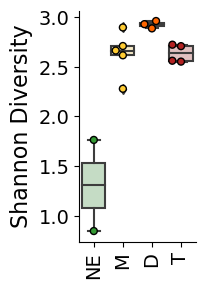

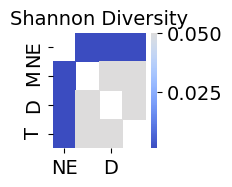

In [19]:
result, pval, tukey_tab = Shan_div(data1=df, sub_l = ['Immune','Epithelial','Mesenchymal'],\
        group_com = 'consensus diagnosis', per_categ = 'Cell Type',\
        rep='cons_replicate', sub_collumn='Major Cell Cat',normalize=True, save=False,\
                          coloring=dis_map, fig_size=1.5, ordering=con_order,)

<ipython-input-10-199b3316927e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1[per_cat] = test1[per_cat].astype('category')
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


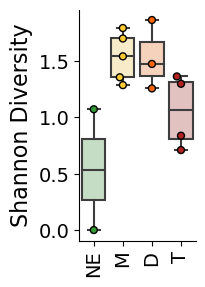

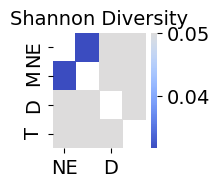

In [174]:
result, pval, tukey_tab = Shan_div(data1=df, sub_l = ['Immune',],\
        group_com = 'consensus diagnosis', per_categ = 'community',\
        rep='cons_replicate', sub_collumn='Major Cell Cat',normalize=True, save=False,\
                          coloring=dis_map, fig_size=1.5, ordering=con_order,)

<ipython-input-10-199b3316927e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1[per_cat] = test1[per_cat].astype('category')
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decreas

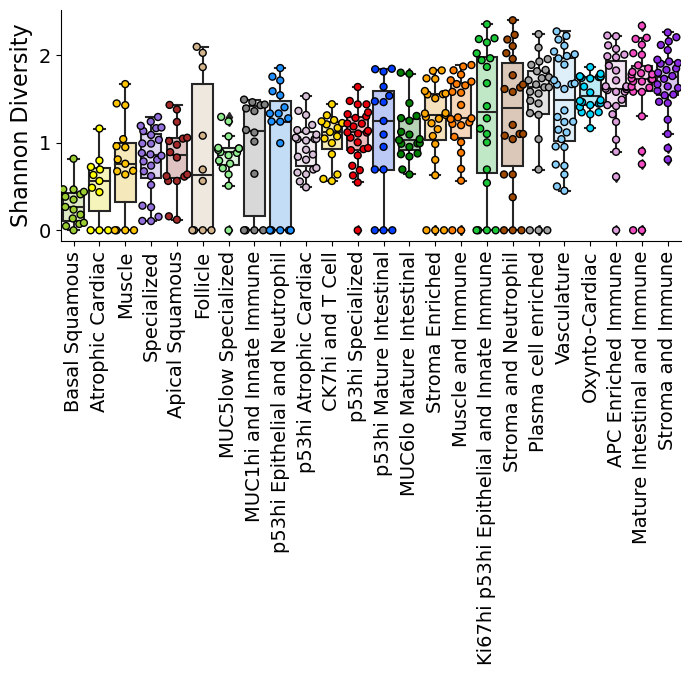

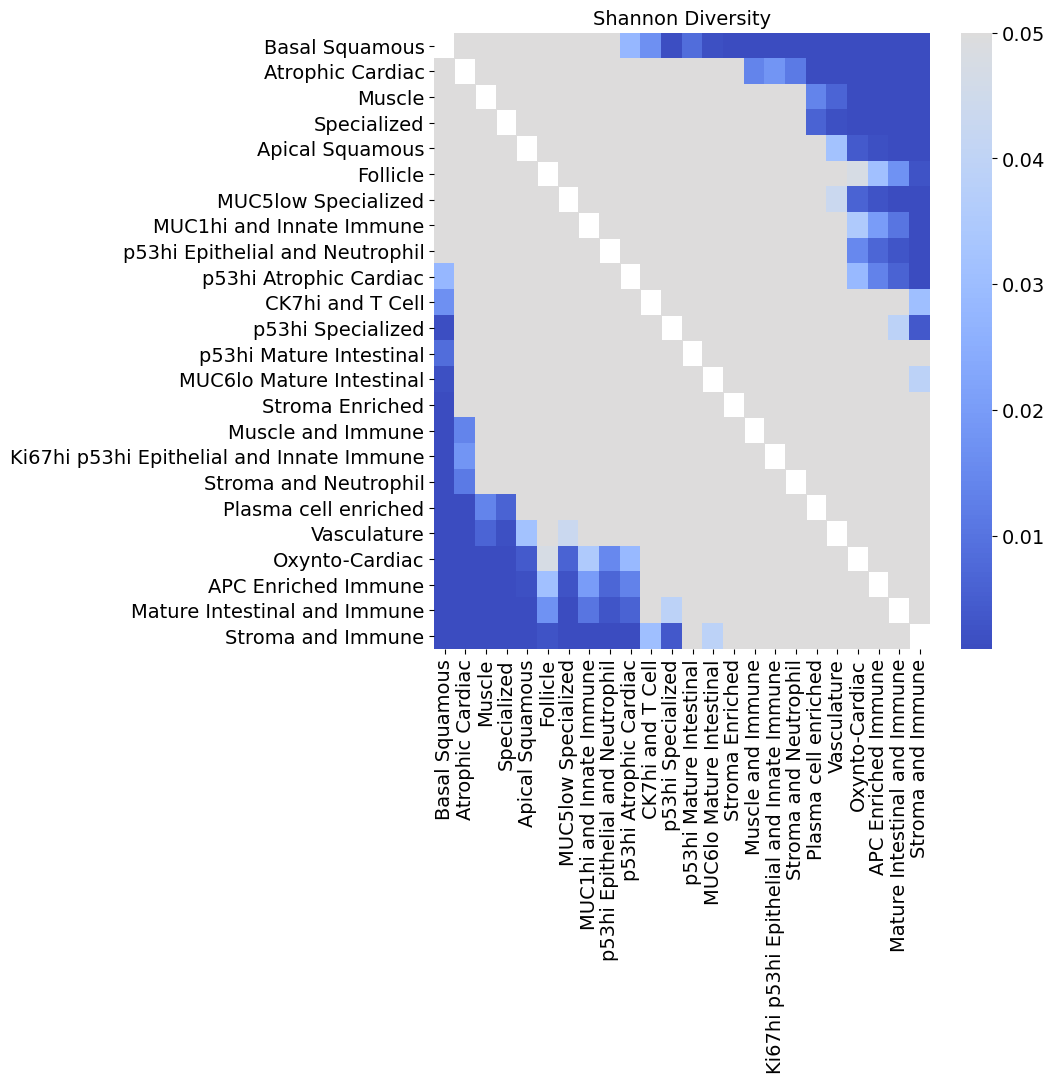

In [161]:
result, pval, tukey_tab = Shan_div(data1=df, sub_l = ['Epithelial'], group_com = 'neigh_name', per_categ = 'Cell Type',\
        rep='unique_region', sub_collumn='Major Cell Cat',normalize=True, save=False,\
                          coloring=neigh_map, fig_size=8)

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/py

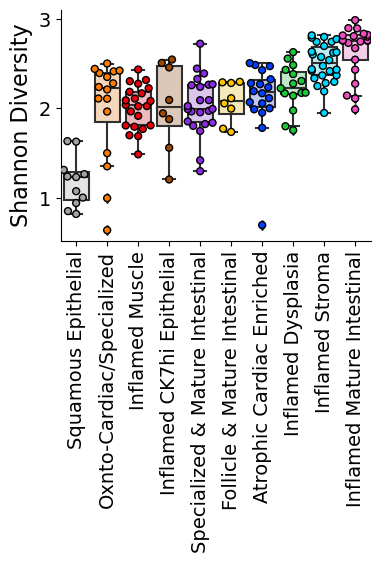

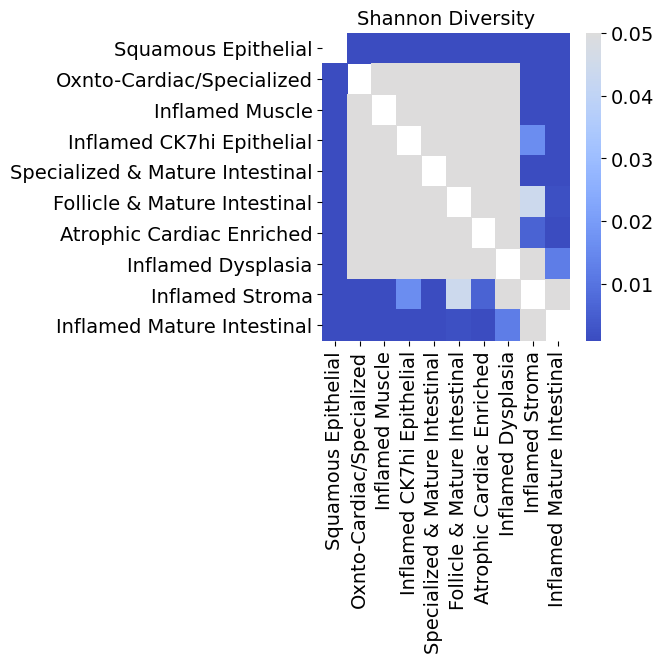

In [158]:
result, pval, tukey_tab = Shan_div(data1=df, sub_l = ['Epithelial','Immune','Mesenchymal'], group_com = 'community', per_categ = 'Cell Type',\
        rep='unique_region', sub_collumn='Major Cell Cat',normalize=True, save=False,\
                          coloring=comm_map, fig_size=4)

<ipython-input-10-199b3316927e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1[per_cat] = test1[per_cat].astype('category')
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


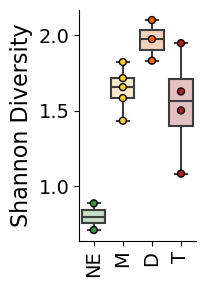

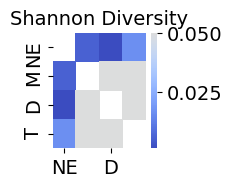

In [166]:
result, shannon, tuk_p = Shan_div(data1=df, sub_l = ['Epithelial'], group_com = 'consensus diagnosis', per_categ = 'Cell Type',\
        rep='cons_replicate', sub_collumn='Major Cell Cat',normalize=True, ordering=con_order, save=True)

In [85]:
#Signficance for all cell types
sub_list = list(df['Major Cell Cat'].unique())
tt = per_only1(data = df, per_cat = 'p53 label', grouping = 'consensus diagnosis',\
          sub_list=sub_list, replicate='cons_replicate', sub_col = 'Major Cell Cat', norm=False)

st1 = anova_tests(data=tt, index_list = ['p53 label','cons_replicate'], col='consensus diagnosis')
#tukey_pa(cell_data=tt, anova_dict=st1,order_set = con_order, col='Cell Type', column='consensus diagnosis',save_name='_test') 
sig_dict = {k:v for (k,v) in st1.items() if v <0.05}
sig_dict

{'CD4+ Treg': 0.0025375127663070066,
 'Foveloar': 0.001396843533934663,
 'Neck': 0.0005898253911793208,
 'Squamous': 3.0726089741508563e-06,
 'p53+ Epithelial': 0.016611904967202062}

In [ ]:
#Signficance for all cell types
sub_list = list(df['Major Cell Cat'].unique())
tt = per_only1(data = df, per_cat = 'Cell Type', grouping = 'consensus diagnosis',\
          sub_list=sub_list, replicate='cons_replicate', sub_col = 'Major Cell Cat', norm=False)

st1 = anova_tests(data=tt, index_list = ['Cell Type','cons_replicate'], col='consensus diagnosis')
#tukey_pa(cell_data=tt, anova_dict=st1,order_set = con_order, col='Cell Type', column='consensus diagnosis',save_name='_test') 
sig_dict = {k:v for (k,v) in st1.items() if v <0.05}
sig_dict

In [72]:
#Signficance for all cell types
sub_list = list(df['Major Cell Cat'].unique())
tt = per_only1(data = df, per_cat = 'Coarse Cell', grouping = 'consensus diagnosis',\
          sub_list=sub_list, replicate='cons_replicate', sub_col = 'Major Cell Cat', norm=False)

st1 = anova_tests(data=tt, index_list = ['Coarse Cell','cons_replicate'], col='consensus diagnosis')
#tukey_pa(cell_data=tt, anova_dict=st1,order_set = con_order, col='Cell Type', column='consensus diagnosis',save_name='_test') 
sig_dict = {k:v for (k,v) in st1.items() if v <0.05}
sig_dict

{'CD4+ Treg': 0.0025375127663070066,
 'Epithelial': 0.024251922950431867,
 'Foveloar': 0.005124546374541442,
 'Neck': 0.0006121929146233701,
 'Squamous': 3.0726089741508563e-06}

In [20]:
#Signficance for all cell types
sub_list = list(df['Major Cell Cat'].unique())
tt = per_only1(data = df, per_cat = 'Major Cell Cat', grouping = 'consensus diagnosis',\
          sub_list=sub_list, replicate='cons_replicate', sub_col = 'Major Cell Cat', norm=False)

st1 = anova_tests(data=tt, index_list = ['Major Cell Cat','cons_replicate'], col='consensus diagnosis')
#tukey_pa(cell_data=tt, anova_dict=st1,order_set = con_order, col='Major Cell Cat', column='consensus diagnosis',save_name='_test') 
sig_dict = {k:v for (k,v) in st1.items() if v <0.05}
sig_dict

{'Epithelial': 0.0033680730189776862, 'Immune': 0.024770516811461266}

In [ ]:
#Get percentages (not normalized for each condition)
df_dict = {}
tt = {}
for tu in list(df['consensus diagnosis'].unique()):
    df_tu = df.loc[df['consensus diagnosis']==tu]
    df_dict[tu] =df_tu
    for dftu in df_dict.keys():
        #Area plot
        sub_list = list(df_dict[dftu]['Cell subtype'].unique())
        tt[dftu] = per_only(data = df_dict[dftu], per_cat = 'Cell Type', grouping = 'consensus diagnosis',\
                  sub_list=sub_list, replicate='donor', sub_col = 'Cell subtype', norm=False,)

#Perform Anova and Tukey tests for each condition
st1 = {}
for dftu in tt.keys():
    st1[dftu] = anova_tests(data=tt[dftu])
    tukey_pa(cell_data=tt[dftu], anova_dict=st1[dftu], save_name='_'+dftu) 
    
#Return Sig dict
cell_Anova = {}
for dftu in st1.keys():
    cell_Anova[dftu] = {k:v for (k,v) in st1[dftu].items() if v <0.05}
cell_Anova

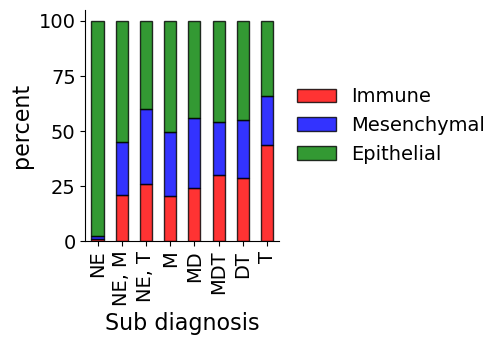

In [21]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = list(df['Major Cell Cat'].unique())
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Major Cell Cat', grouping = 'Sub diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(2.5,3), name_cat ='Major Cell Cat',  \
                    col_order=sub_order,save_name='Major_subConsensus', pal_color=Maj_map,) #h_order=h_ordertu,  pal_color=col_map

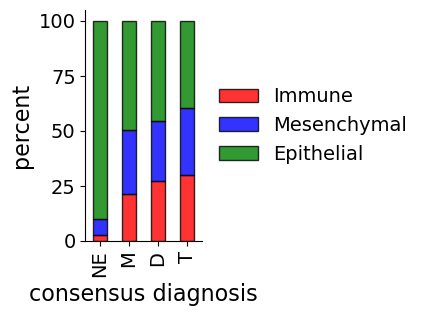

In [22]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = list(df['Major Cell Cat'].unique())
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Major Cell Cat', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Major Cell Cat',  \
                    col_order=con_order,save_name='Major_Consensus', pal_color=Maj_map,) #h_order=h_ordertu, 

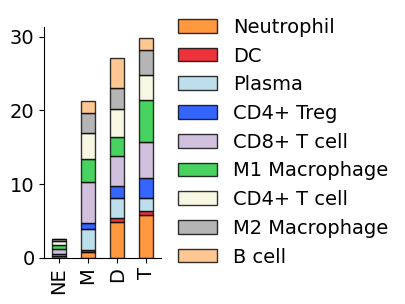

In [26]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Immune']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Coarse Cell',  \
                    col_order=con_order,save_name='Imm_Cell_Subconsensus',pal_color=cell_map, remove_leg=True)

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 150x300 with 0 Axes>

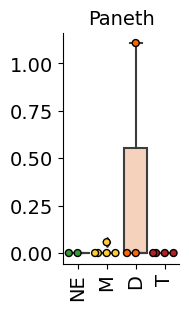

In [20]:
sub_list = ['Paneth']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Cell Type', sub_list=sub_list, norm=False, per_cat= 'Cell Type', \
                           figure_sizing=(1.5,3),  pal_color=dis_map, h_order=con_order,\
                           flip=True) #save_name='sig_imm_cons',

<Figure size 150x300 with 0 Axes>

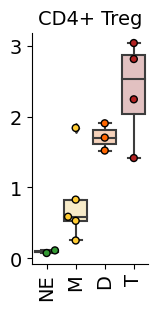

In [68]:
sub_list = ['CD4+ Treg']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Cell Type', sub_list=sub_list, norm=False, per_cat= 'Cell Type', \
                           figure_sizing=(1.5,3), save_name='sig_imm_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

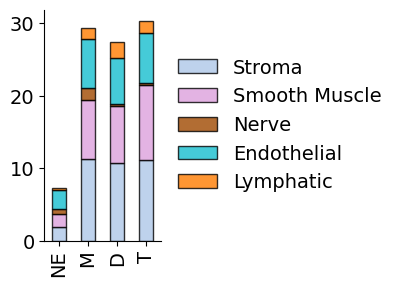

In [27]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Mesenchymal']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Coarse Cell',  \
                    col_order=con_order,save_name='Mes_Cell_Subconsensus',pal_color=cell_map, remove_leg=True)

<Figure size 150x300 with 0 Axes>

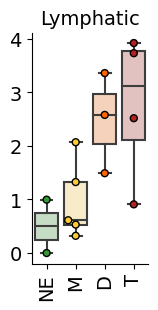

In [69]:
sub_list = ['Lymphatic']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Cell Type', sub_list=sub_list, norm=False, per_cat= 'Cell Type', \
                           figure_sizing=(1.5,3), save_name='sig_lymph_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

<Figure size 150x300 with 0 Axes>

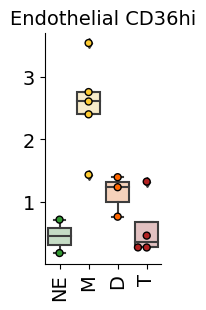

In [76]:
sub_list = ['Endothelial CD36hi']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Cell Type', sub_list=sub_list, norm=False, per_cat= 'Cell Type', \
                           figure_sizing=(1.5,3), save_name='sig_end_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

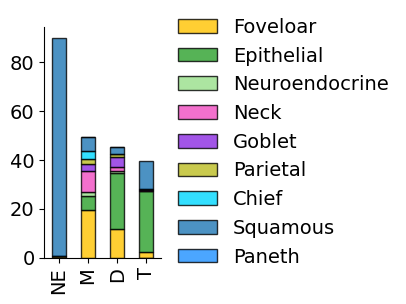

In [28]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Coarse Cell',  \
                    col_order=con_order,save_name='Epi_Cell_Subconsensus',pal_color=cell_map, remove_leg=True)

<Figure size 150x300 with 0 Axes>

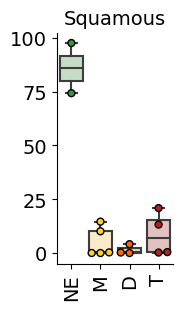

In [75]:
sub_list = ['Squamous']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Coarse Cell', sub_list=sub_list, norm=False, per_cat= 'Coarse Cell', \
                           figure_sizing=(1.5,3), save_name='sig_squam_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

<Figure size 150x300 with 0 Axes>

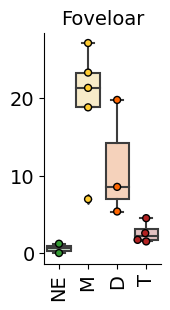

In [79]:
sub_list = ['Foveloar']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Coarse Cell', sub_list=sub_list, norm=False, per_cat= 'Coarse Cell', \
                           figure_sizing=(1.5,3), save_name='sig_fov_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 150x300 with 0 Axes>

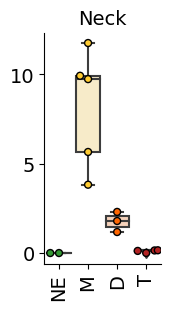

In [80]:
sub_list = ['Neck']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Coarse Cell', sub_list=sub_list, norm=False, per_cat= 'Coarse Cell', \
                           figure_sizing=(1.5,3), save_name='sig_neck_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

<Figure size 150x300 with 0 Axes>

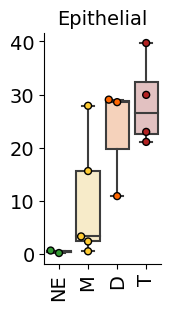

In [81]:
sub_list = ['Epithelial']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='Coarse Cell', sub_list=sub_list, norm=False, per_cat= 'Coarse Cell', \
                           figure_sizing=(1.5,3), save_name='sig_epi_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 150x300 with 0 Axes>

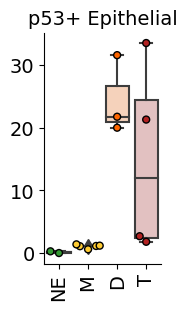

In [86]:
sub_list = ['p53+ Epithelial']
total_neigh_st = swarm_box(data=df, grouping='consensus diagnosis', replicate='cons_replicate',\
                           sub_col='p53 label', sub_list=sub_list, norm=False, per_cat= 'p53 label', \
                           figure_sizing=(1.5,3), save_name='sig_p53_cons', pal_color=dis_map, h_order=con_order,\
                           flip=True)

# Correlation

In [149]:
def cor_subset(cor_mat, threshold, cell_type):
    pairs = get_top_abs_correlations(cor_mat,thresh=threshold)
    
    piar1 = pairs.loc[pairs['col1']==cell_type]
    piar2 = pairs.loc[pairs['col2']==cell_type]
    piar=pd.concat([piar1,piar2])
    
    pair_list = list(set(list(piar['col1'].unique())+list(piar['col2'].unique())))
    
    return pair_list, piar, pairs

def cor_subplot(mp, sub_list,save_name=None):
    sub_cor = mp[sub_list]
    sns.pairplot(sub_cor,diag_kind = 'kde',
                             plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80, 'edgecolor': 'k'}},
                             size = 4, kind='reg', corner=True)
    if save_name:
        plt.savefig(save_path+save_name+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


In [147]:
def corr_cell(data,  sub_l2, per_categ, group2, repl, sub_collumn, cell,\
              thres = 0.9, normed=True, cell2=None):
    result = per_only1(data = df, per_cat = per_categ, grouping=group2,\
                      sub_list=sub_l2, replicate=repl, sub_col = sub_collumn, norm=normed)

    #Format for correlation function
    mp = pd.pivot_table(result, columns = [per_categ], index=[group2,repl], values=['percentage'])
    mp.columns = mp.columns.droplevel(0)
    cc = mp.reset_index()
    cmat = cc.corr()

    #Plot
    sl2, pair2, all_pairs = cor_subset(cor_mat=cmat, threshold = thres, cell_type=cell)
    
    if cell2:
        sl3 = [cell2, cell]
        cor_subplot(mp=cc, sub_list=sl3, save_name=cell+'_'+cell2)
    else:
        cor_subplot(mp=cc, sub_list=sl2, save_name=cell)
    
    return all_pairs, pair2

/Users/jwhickey/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


col1                   col2     value
0        Foveloar p53+            Goblet p53+  0.999957
1      Epithelial CK7+            Goblet p53+  0.999746
2    Goblet Ki67+ p53+                 Paneth  0.999712
3      Epithelial CK7+          Foveloar p53+  0.999606
4        Foveloar p53+      Goblet Ki67+ p53+  0.997690
..                 ...                    ...       ...
56               Chief        Lymphatic CD73+  0.705547
57     Lymphatic CD73+          M2 Macrophage  0.704941
58       M2 Macrophage           Stroma CD73+  0.704066
59           CD4+ Treg  Epithelial Ki67+ p53+  0.700587
989          CD4+ Treg     Endothelial CD36hi -0.762162

[61 rows x 3 columns]

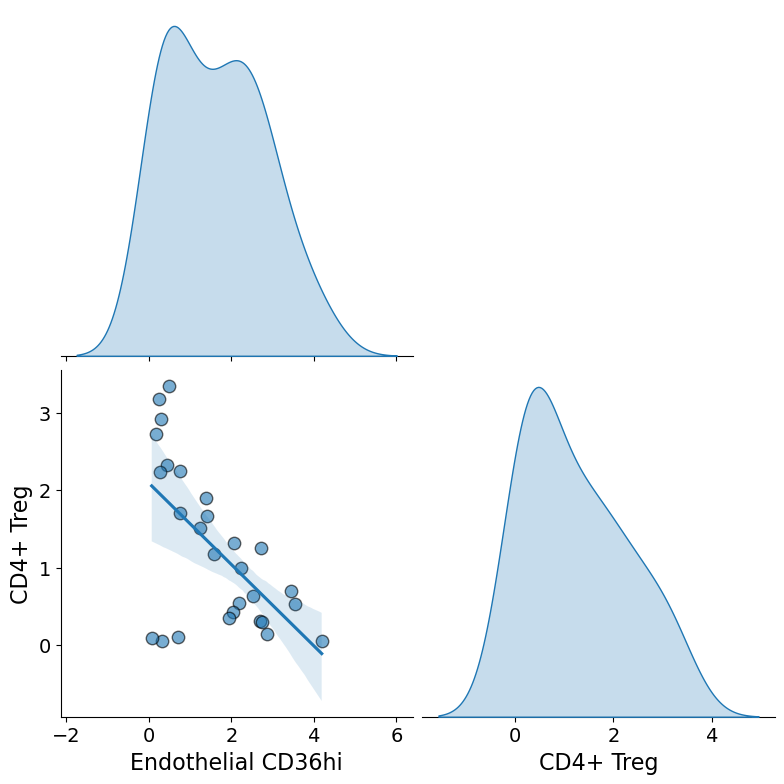

In [150]:
sub_l = ['Immune','Epithelial','Mesenchymal']
all_pair, sub_pari = corr_cell(data=df,  sub_l2=sub_l, per_categ='Cell Type', group2='Sub diagnosis', \
                               repl='unique_region',  sub_collumn= 'Major Cell Cat', cell='CD4+ Treg',\
                               normed=True, thres=0.7, cell2 = 'Endothelial CD36hi')
all_pair

# Tissue Plots

In [151]:
cellhier_path = '/Users/jwhickey/Documents/Stanford/python_code/cellhier'
sys.path.append(cellhier_path)
from cellhier.general import *

E08_reg001


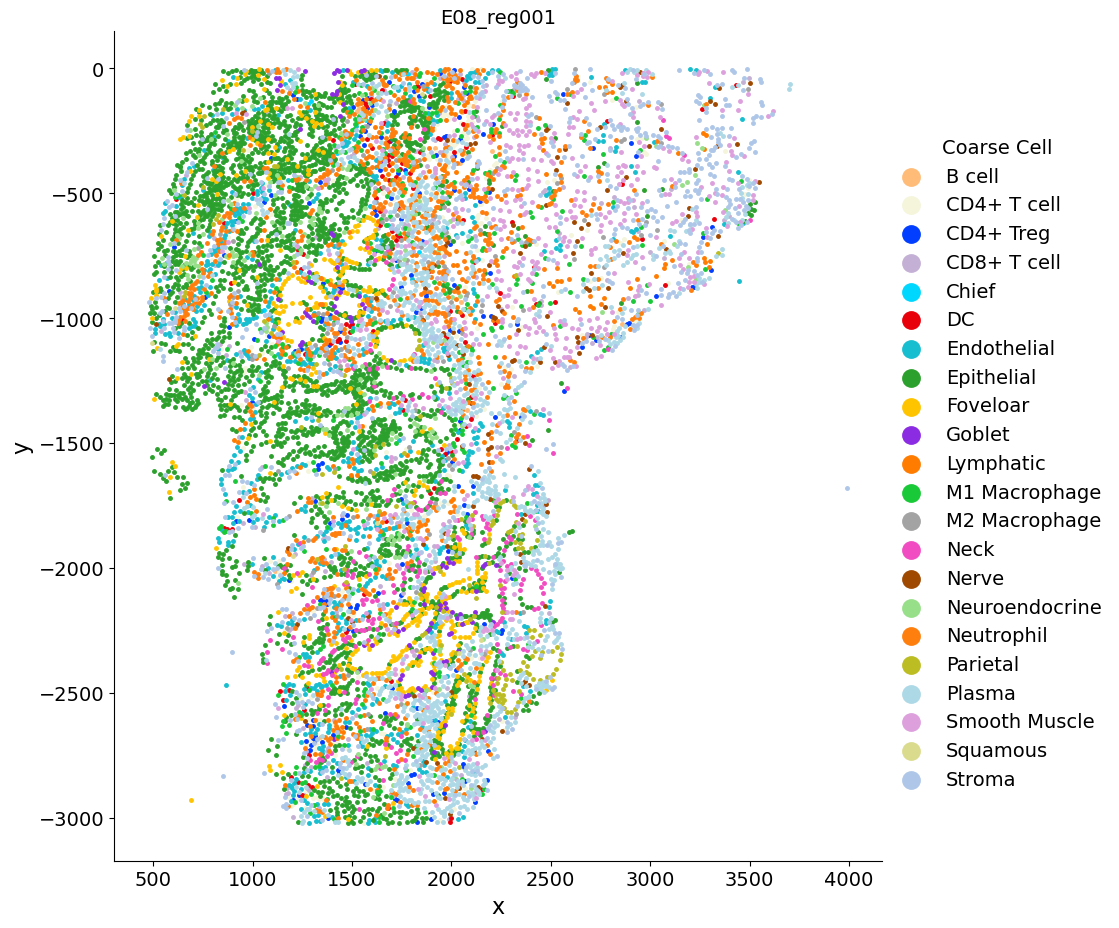

E08_reg002


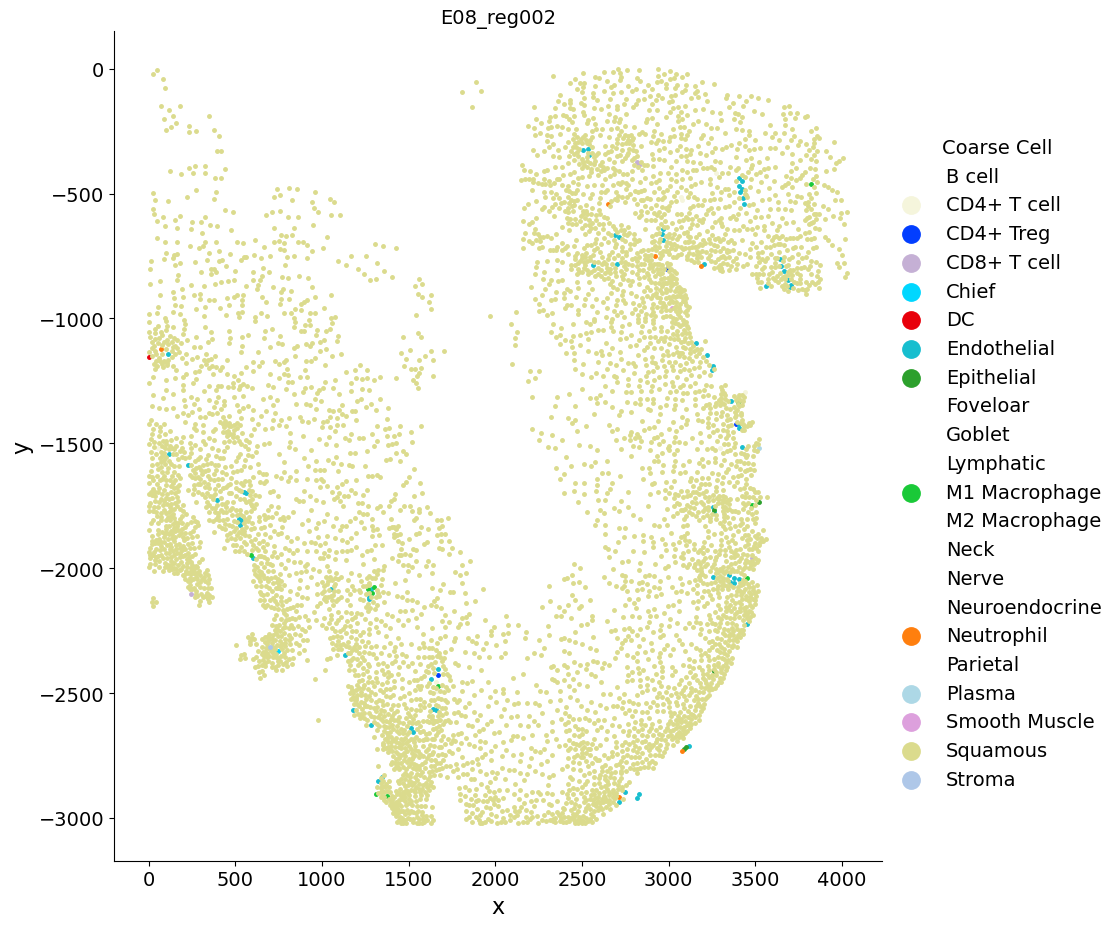

E08_reg003


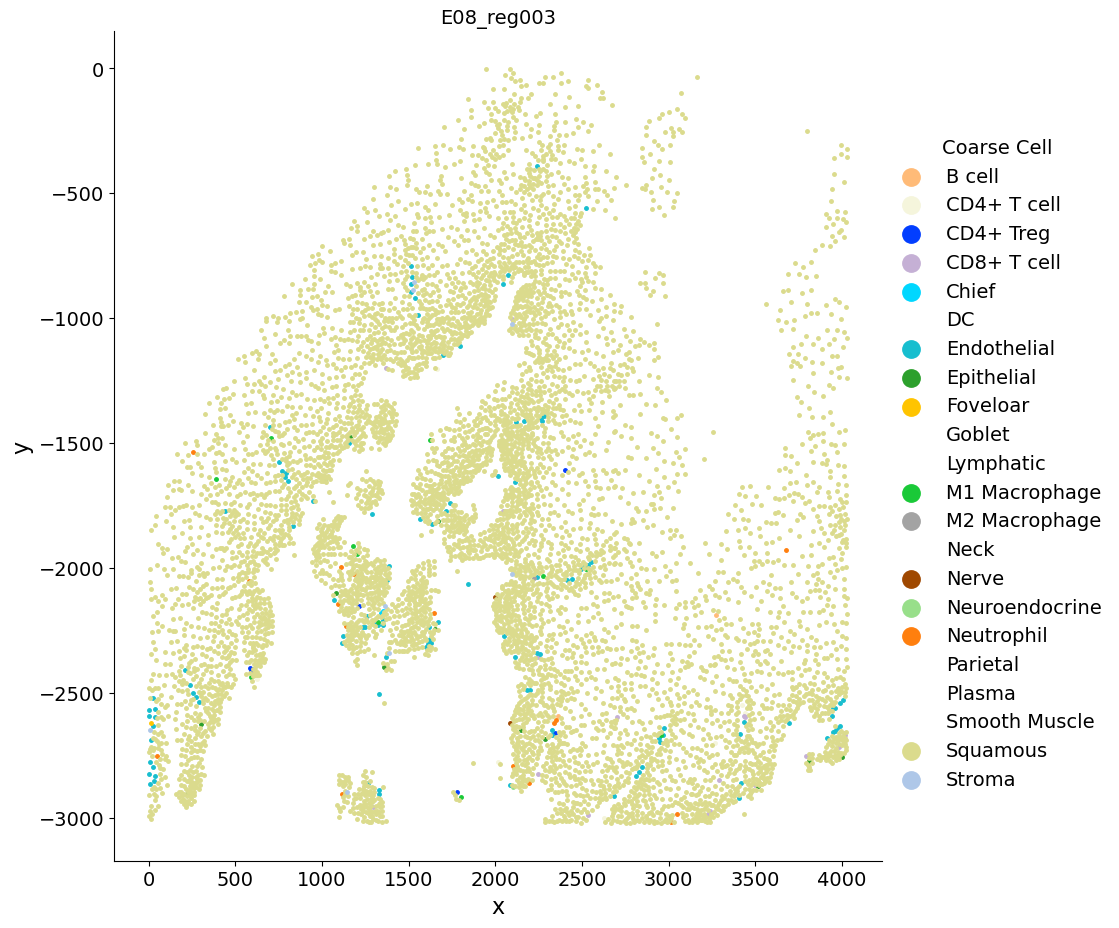

E08_reg004


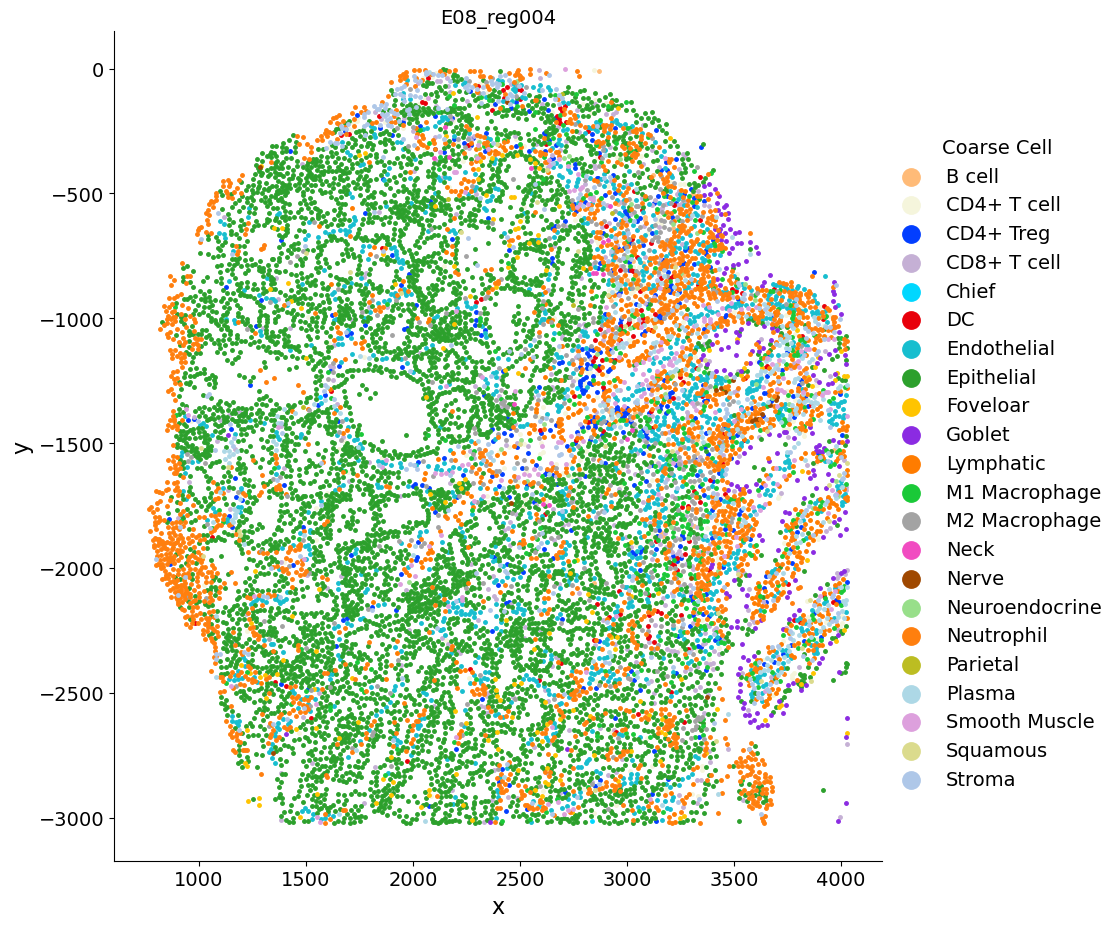

E08_reg005


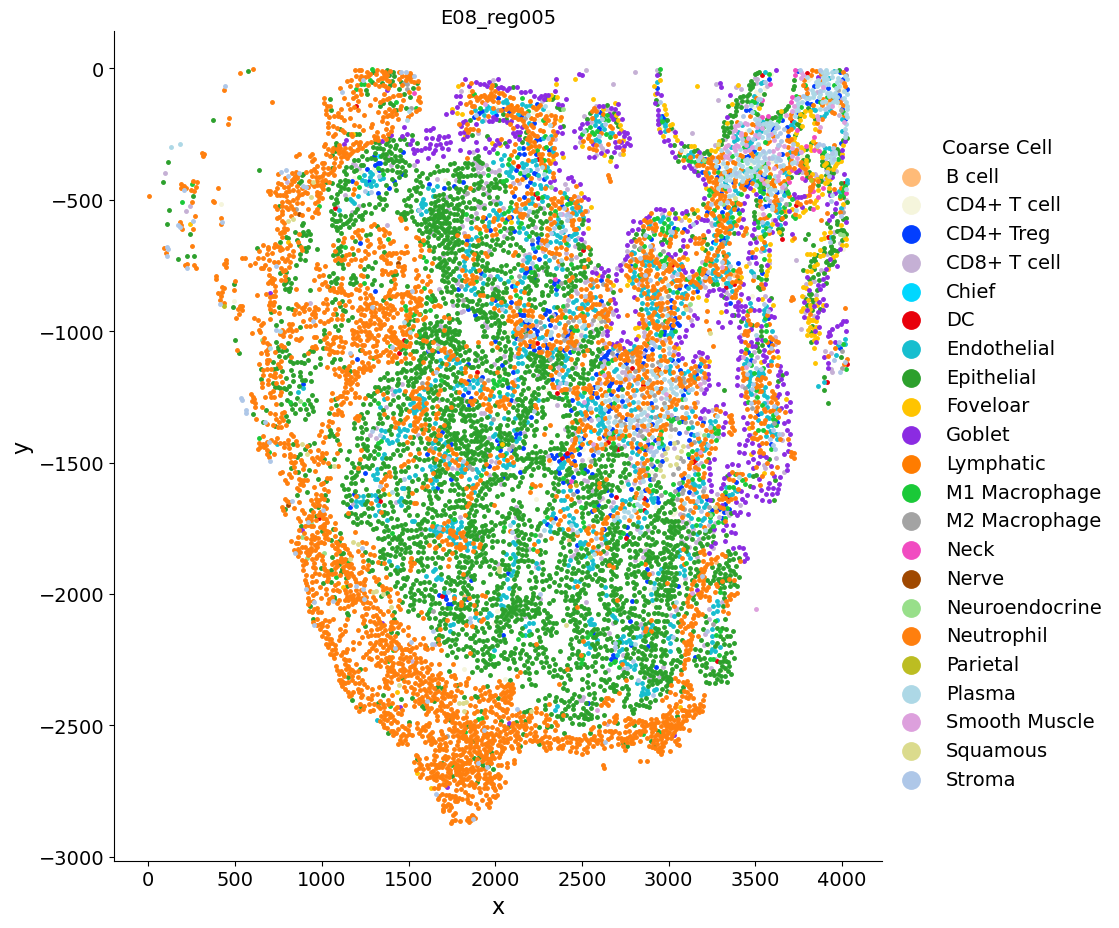

E08_reg006


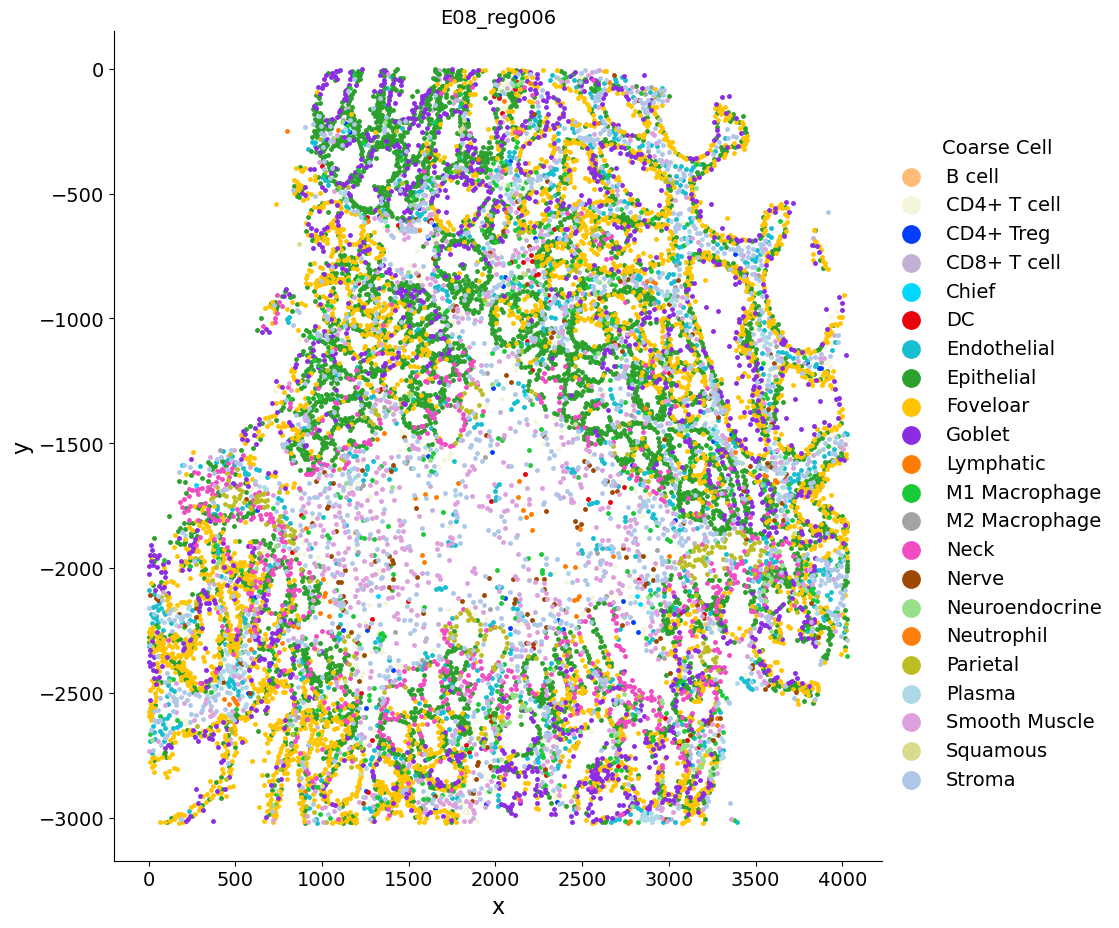

E08_reg007


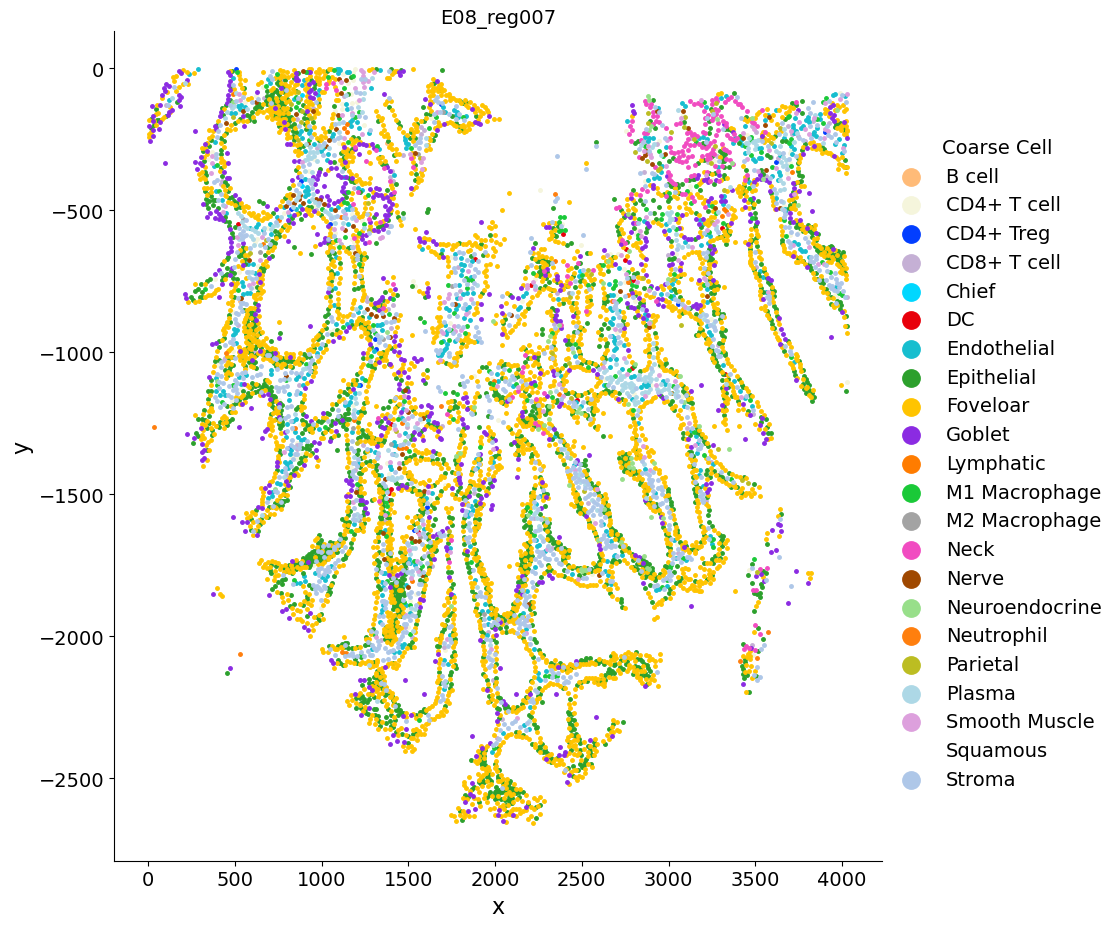

In [161]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 5
X = 'x'
Y = 'y'
reg = 'unique_region'
df_sub = df.loc[df['sample']=='E08']
figs1 = catplot(df_sub,X = X,Y=Y,exp = reg,
               hue = 'Coarse Cell',invert_y=True,size = 25,figsize=9, palette=coarse_map)

E08_reg001


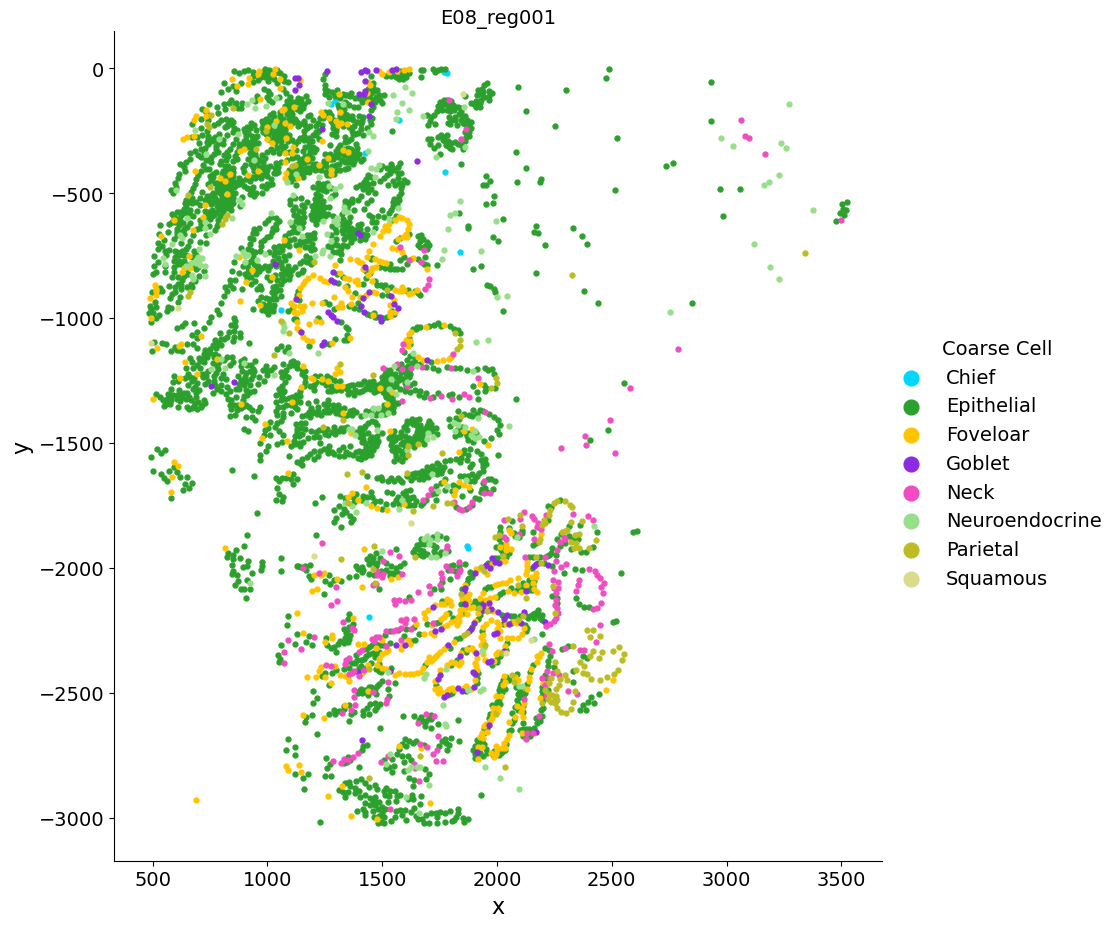

E08_reg002


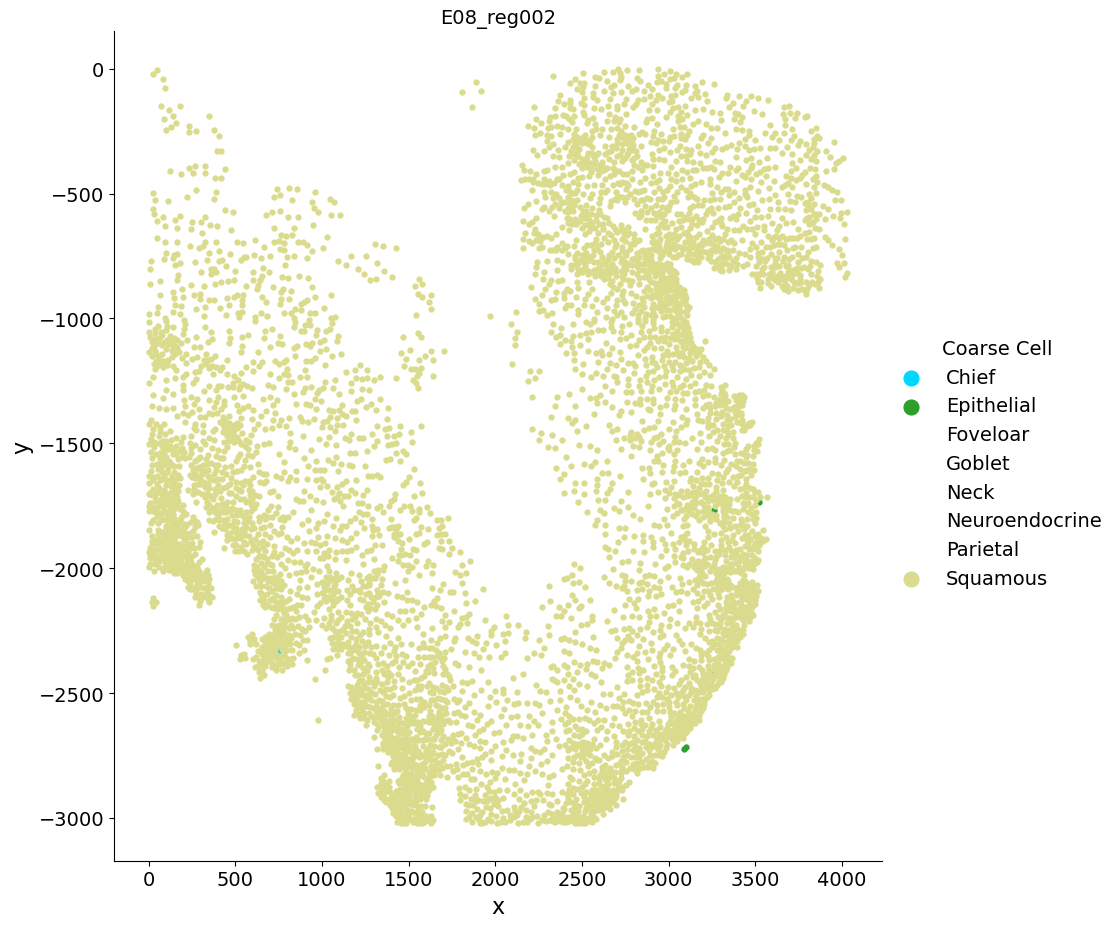

E08_reg003


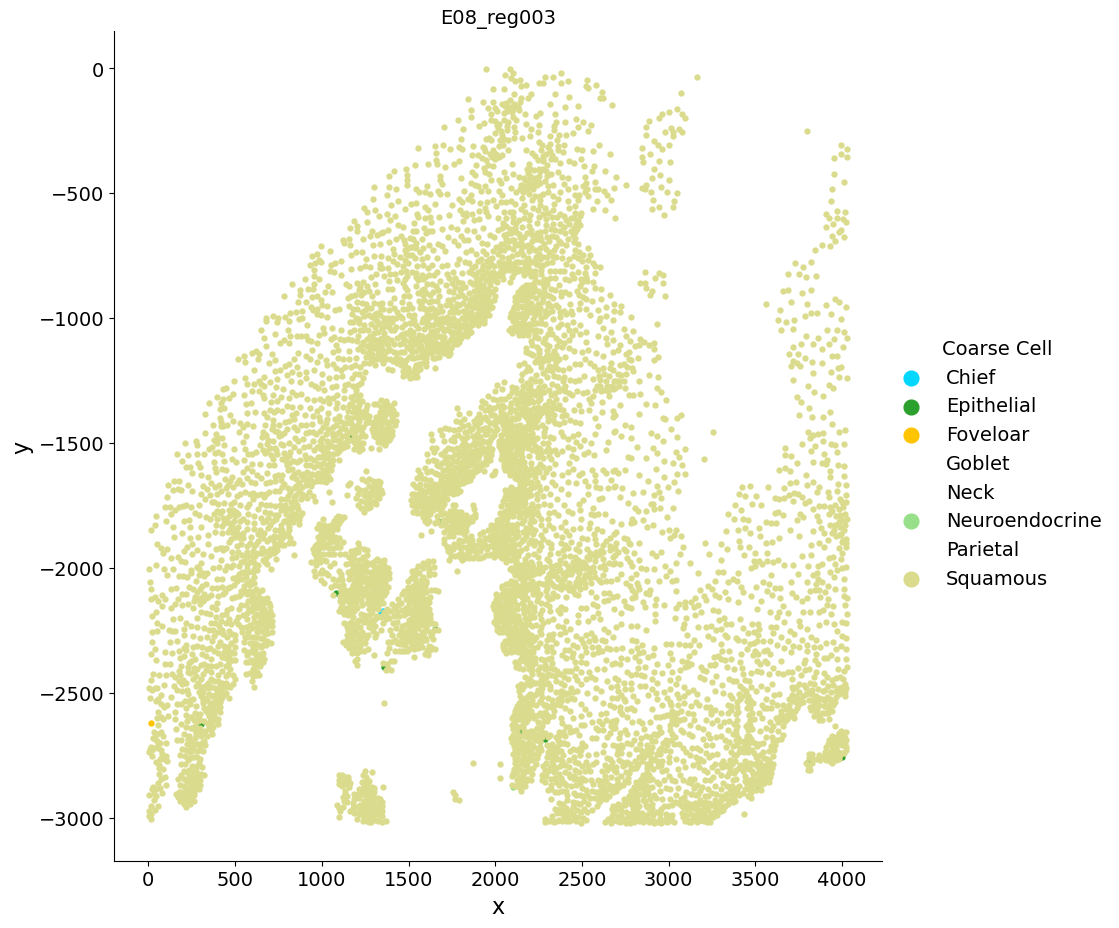

E08_reg004


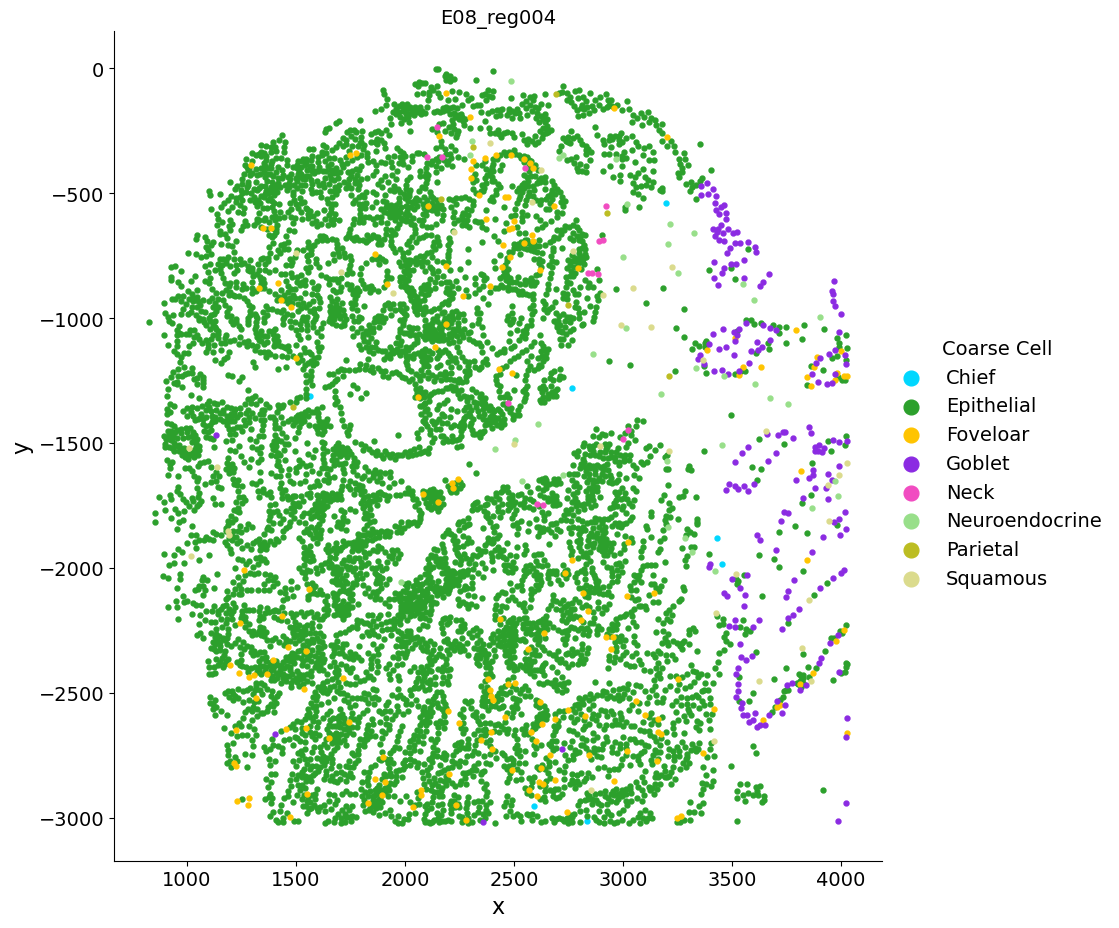

E08_reg005


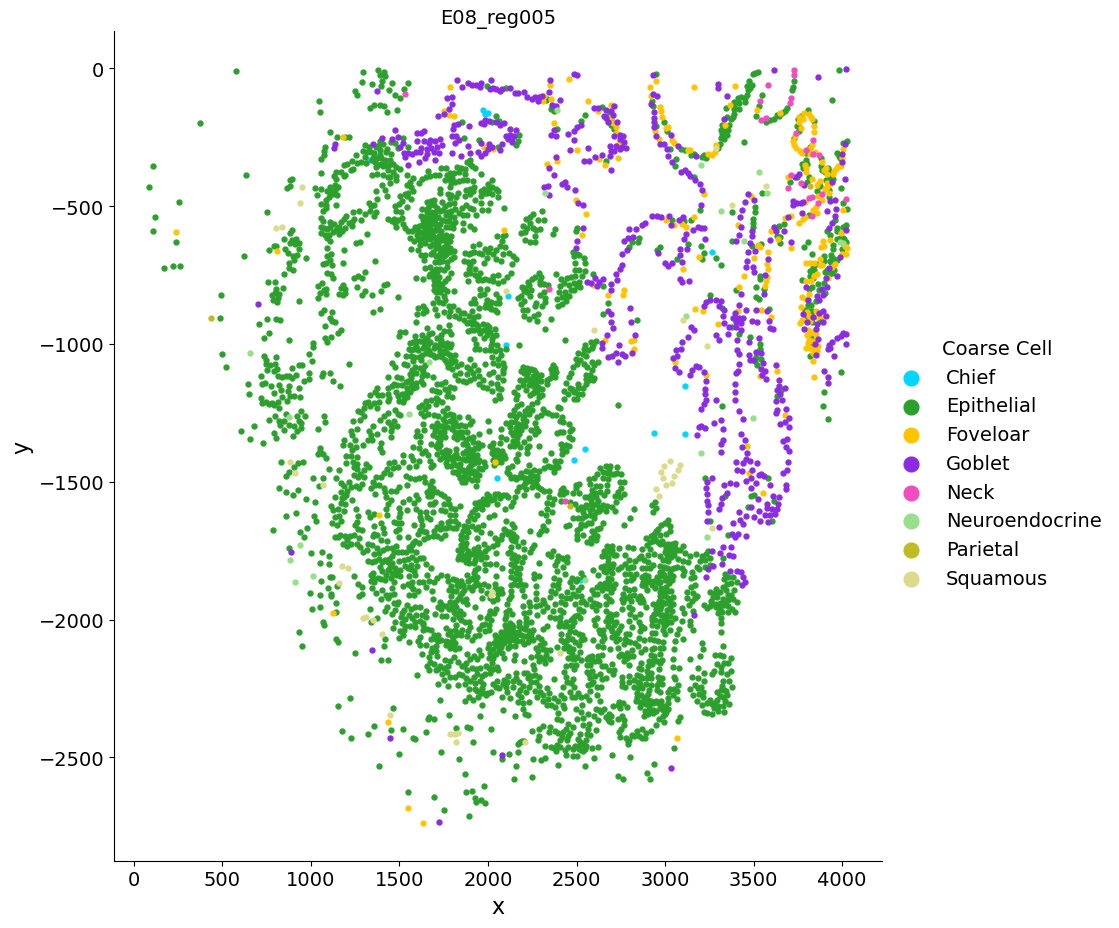

E08_reg006


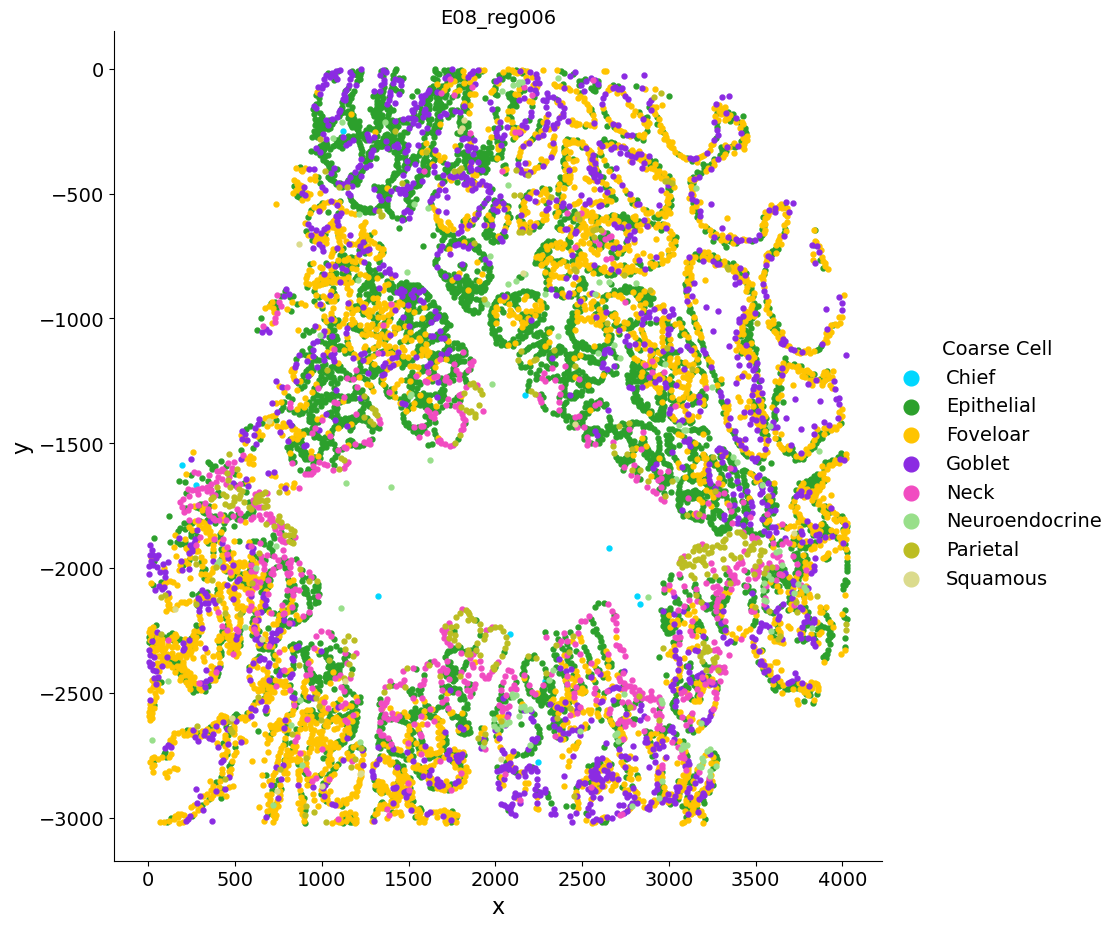

E08_reg007


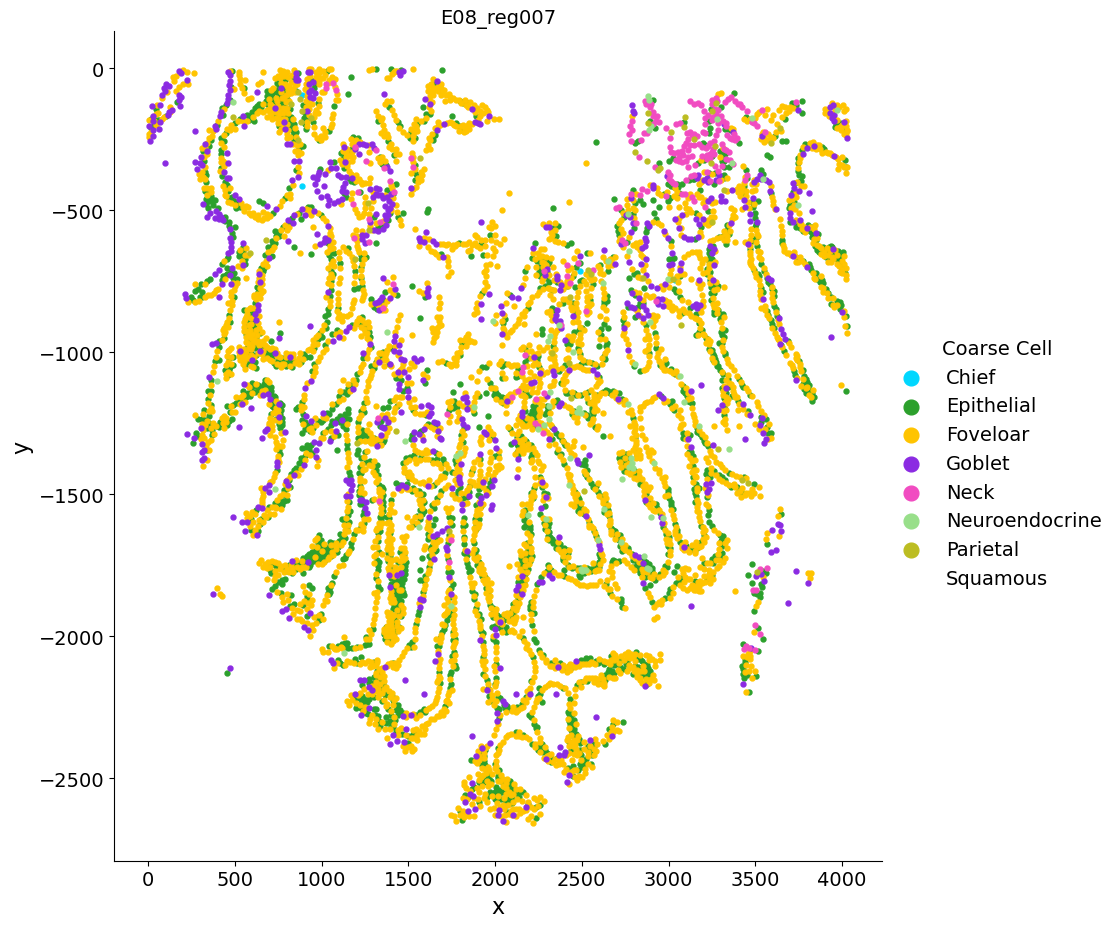

In [166]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 3
X = 'x'
Y = 'y'
reg = 'unique_region'
df_sub = df.loc[df['sample']=='E08']
df_sub2 = df_sub.loc[df_sub['Major Cell Cat']=='Epithelial']
figs2 = catplot(df_sub2,X = X,Y=Y,exp = reg,
               hue = 'Coarse Cell',invert_y=True,size = 50,figsize=9, palette=coarse_map)

In [164]:
for n,f in enumerate(figs1):
    f.savefig(save_path+'all_coarse_cell{}.png'.format(n), dpi=600, transparent=True)

In [167]:
for n,f in enumerate(figs2):
    f.savefig(save_path+'epi_coarse_cell{}.png'.format(n), dpi=600, transparent=True)

In [ ]:
def corr_cell(data, s_name, sub_col, per_c, groupA, rep, sub_l,  threshold = 0.7):

    result = per_only1(data = data, per_cat = per_c, grouping = groupA,\
                      sub_list=sub_l, replicate=rep, sub_col = sub_col, norm=True,)

    #Format for correlation function
    mp = pd.pivot_table(result, columns = [per_c], index=[groupA,rep], values=['percentage'])
    mp.columns = mp.columns.droplevel(0)
    cc = mp.reset_index()
    
    cmat = cc.corr()
    
    
    cc[meta_col] = cc[meta_col].astype(float)
    data_cor = {}
    for un_con in list(cc[groupA].unique()):
        cc_un = cc.loc[cc[groupA]==un_con]
        cmat = cc_un.corr()
    
        #Select only BMI interesting correlations
        BMI_val = cmat[meta_col][1:]
        BMI_cor = BMI_val.to_frame()

        #Get anything greater than threshold
        gt_pair = BMI_cor.loc[BMI_cor[meta_col].abs().gt(threshold)]
        pair_list = gt_pair.index.to_list()
        pair_list.append(meta_col)

        #Plot the correlations
        sub_cor = cc_un[pair_list]
       
        if sub_cor.shape[1]<2:
            continue
        else:
            data_cor[un_con] = gt_pair
            sns.pairplot(sub_cor,diag_kind = 'kde',
                                     plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80/len(pair_list), 'edgecolor': 'k'}},
                                     size = 10/len(pair_list), kind='reg', aspect=1)

            plt.savefig(save_path+s_name+'_'+un_con+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

    return data_cor

In [ ]:
def cor_plot(data, group1,per_cat, sub_col=None,sub_list=None,norm=False,\
             group2=None, count=False, plot_scatter=True):
    if group2:
        plt.rcParams["legend.markerscale"] = 1
        tf = data.groupby([group1,group2]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100).to_frame()
        tf.columns = tf.columns.astype(str)
        tf.reset_index(inplace=True)
        mp = pd.pivot_table(tf, columns = ['level_2'], index=[group1,group2], values=[per_cat])
        mp.columns = mp.columns.droplevel(0)
        mp.reset_index(inplace=True)
        mp2 = mp.fillna(0)
        cor_mat = mp2.corr()
        mask = np.triu(np.ones_like(cor_mat, dtype=bool))
        plt.figure(figsize = (len(cor_mat.index),len(cor_mat.columns)*0.8))
        sns.heatmap(cor_mat, cmap='coolwarm',center=0,vmin=-1,vmax=1,mask=mask)
        if plot_scatter:
            sns.pairplot(mp,diag_kind = 'kde',
                     plot_kws ={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                     size = 4, hue=group2)
    else:
        if count:
                tf = data.groupby([group1,per_cat]).count()['region'].to_frame()
                tf.reset_index(inplace=True)
                mp = pd.pivot_table(tf, columns = [per_cat], index=[group1], values=['region'])
                mp.columns = mp.columns.droplevel(0)
                mp.reset_index(inplace=True)
                mp2 = mp.fillna(0)
                cor_mat = mp2.corr()
                mask = np.triu(np.ones_like(cor_mat, dtype=bool))
                plt.figure(figsize = (len(cor_mat.index),len(cor_mat.columns)*0.8))
                sns.heatmap(cor_mat, cmap='coolwarm',center=0,vmin=-1,vmax=1,mask=mask)
                if plot_scatter:
                    sns.pairplot(mp,diag_kind = 'kde',
                                 plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80, 'edgecolor': 'k'}},
                                 size = 4, kind='reg')
        else:
            #Find Percentage of cell type
            test= data.copy()
            sub_list1 = sub_list.copy()

            if norm==True:
                test1 = test.loc[test[sub_col].isin(sub_list1)]
                immune_list = list(test1[per_cat].unique())
            else:
                test1=test.copy()
                immune_list = list(test.loc[test[sub_col].isin(sub_list1)][per_cat].unique())

            test1[per_cat] = test1[per_cat].astype('category')
            tf = test1.groupby([group1]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
            tf.columns = tf.columns.astype(str)
            mp = tf[immune_list]
            mp.reset_index(inplace=True)
            cor_mat = mp.corr()
            mask = np.triu(np.ones_like(cor_mat, dtype=bool))
            plt.figure(figsize = (len(cor_mat.index),len(cor_mat.columns)*0.8))
            sns.heatmap(cor_mat, cmap='coolwarm',center=0,vmin=-1,vmax=1,mask=mask)
            if plot_scatter:
                sns.pairplot(mp,diag_kind = 'kde',
                             plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80, 'edgecolor': 'k'}},
                             size = 4, kind='reg')

        
    return cor_mat, mp

In [87]:
# def get_redundant_pairs(df):
#     '''Get diagonal and lower triangular pairs of correlation matrix'''
#     pairs_to_drop = set()
#     cols = df.columns
#     for i in range(0, df.shape[1]):
#         for j in range(0, i+1):
#             pairs_to_drop.add((cols[i], cols[j]))
#     return pairs_to_drop

# def get_top_abs_correlations(df, thresh=0.5):
#     au_corr = df.corr().unstack()
#     labels_to_drop = get_redundant_pairs(df)
#     au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
#     cc = au_corr.to_frame()
#     cc.index.rename(['col1','col2'],inplace=True)
#     cc.reset_index(inplace=True)
#     cc.rename(columns={0:'value'},inplace=True)
#     gt_pair = cc.loc[cc['value'].abs().gt(thresh)]
#     return gt_pair

In [36]:
sl2, pair2 = cor_subset(cor_mat=cor_mat_cell, threshold=0.68, cell_type='Epithelial CK7+')
cor_subplot(mp=mp_cell, sub_list=sl2)#, save_name='CK7')
pair2

col1               col2     value
1   Epithelial CK7+        Goblet p53+  0.999723
8   Epithelial CK7+  Goblet Ki67+ p53+  0.995091
9   Epithelial CK7+             Paneth  0.993867
17  Epithelial CK7+    Neck Ki67+ p53+  0.916657
3     Foveloar p53+    Epithelial CK7+  0.999571

In [38]:
cor_mat_neigh.columns

Index(['p53hi Mature Intestinal', 'Oxynto-Cardiac', 'p53hi Specialized',
       'Smooth Muscle n', 'Stroma and Immune', 'Smooth Muscle and Immune',
       'Ki67hi p53hi Epithelial and Innate Immune', 'Plasma cell enriched',
       'Mature Intestinal and Immune', 'Stroma and Neutrophil',
       'p53hi Epithelial and Neutrophil', 'Vasculature', 'APC Enriched Immune',
       'Stroma n', 'Specialized', 'p53hi Atrophic Cardiac',
       'MUC5low Specialized', 'MUC6lo Mature Intestinal', 'CK7hi and T Cell',
       'Atrophic Cardiac', 'MUC1hi and Innate Immune', 'Apical Squamous',
       'Basal Squamous', 'Follicle'],
      dtype='object', name='neigh_name')

In [57]:
sl2, pair2 = cor_subset(cor_mat=cor_mat_neigh, threshold=0.6, cell_type='CK7hi and T Cell')
#cor_subplot(mp=mp_neigh, sub_list=sl2)#, save_name='CK7')
pair2

col1              col2     value
20  Mature Intestinal and Immune  CK7hi and T Cell  0.616731

In [58]:
cor_mat_com.columns

Index(['Inflamed Dysplasia', 'Inflamed Mature Intestinal', 'Smooth Muscle c',
       'Inflamed Stroma', 'Specialized c', 'Oxnto-Cardiac/Specialized',
       'Atrophic Cardiac c', 'Squamous', 'Follicle c', 'CK7hi and T cell'],
      dtype='object', name='community')

In [72]:
sl2, pair2 = cor_subset(cor_mat=cor_mat_com, threshold=0.6, cell_type='Specialized c')
#cor_subplot(mp=mp_neigh, sub_list=sl2)#, save_name='CK7')
pair2

col1                col2     value
0  Specialized c  Atrophic Cardiac c  0.827782

In [74]:
len(df.unique_region.unique())

32

In [17]:
pairs = get_top_abs_correlations(cor_mat_cell,thresh=0.68)
pairs

col1                   col2     value
0            Foveloar p53+            Goblet p53+  0.999953
1          Epithelial CK7+            Goblet p53+  0.999723
2                   Paneth      Goblet Ki67+ p53+  0.999694
3            Foveloar p53+        Epithelial CK7+  0.999571
4            Foveloar p53+      Goblet Ki67+ p53+  0.997512
5              Goblet p53+      Goblet Ki67+ p53+  0.996893
6            Foveloar p53+                 Paneth  0.996663
7              Goblet p53+                 Paneth  0.996085
8          Epithelial CK7+      Goblet Ki67+ p53+  0.995091
9          Epithelial CK7+                 Paneth  0.993867
10                  Paneth        Neck Ki67+ p53+  0.953329
11       Goblet Ki67+ p53+        Neck Ki67+ p53+  0.951560
12            Stroma CD73+        Lymphatic CD73+  0.950154
13              Neutrophil  Epithelial Ki67+ p53+  0.934173
14           Foveloar p53+        Neck Ki67+ p53+  0.927548
15    Epithelial CK7+ p53+    Squamou p63+ EGFRhi  0.925554
16             Goblet p53+        Neck Ki67+ p53+  0.924430
17         Epithelial CK7+        Neck Ki67+ p53+  0.916657
18                    Neck     Endothelial CD36hi  0.906659
19    Squamous Annexin A1+          Squamous p63+  0.904799
20                   Nerve                   Neck  0.892478
21                Foveloar     Endothelial CD36hi  0.872826
22               Neck p53+        Neck Ki67+ p53+  0.870156
23   Epithelial Ki67+ p53+        Epithelial p53+  0.863014
24                   Nerve     Endothelial CD36hi  0.851712
25      Endothelial aSMAhi    Squamou p63+ EGFRhi  0.848939
26                Foveloar                   Neck  0.844660
27              Neutrophil        Epithelial p53+  0.816355
28             CD4+ T cell                 B cell  0.813636
29    Epithelial CK7+ p53+      Epithelial CD73hi  0.788142
30             CD8+ T cell          M2 Macrophage  0.777790
31   Epithelial Ki67+ p53+                     DC  0.765746
32                Foveloar                 Goblet  0.765719
33           M2 Macrophage       CD8+ T cell PD1+  0.751919
34             CD8+ T cell                  Chief  0.749386
35             CD8+ T cell        Lymphatic CD73+  0.747511
36             Endothelial              CD4+ Treg  0.741855
37            Stroma CD73+              Neck p53+  0.739139
38                      DC          M1 Macrophage  0.733959
39                Parietal                  Chief  0.733367
40      Endothelial aSMAhi   Epithelial CK7+ p53+  0.733222
41           M2 Macrophage        Lymphatic CD73+  0.727047
42           M2 Macrophage           Stroma CD73+  0.718676
43                   Nerve                  Chief  0.705541
44         Epithelial p53+              Lymphatic  0.704370
45                   Chief     Endothelial CD36hi  0.704138
46                    Neck                  Chief  0.702551
47              Neutrophil              CD4+ Treg  0.689278
48            Stroma CD73+        Neck Ki67+ p53+  0.685389
49               CD4+ Treg              Lymphatic  0.683645
50               Neck p53+                 Paneth  0.680885
989              CD4+ Treg     Endothelial CD36hi -0.749192

In [20]:
cell_type = 'Epithelial CK7+'
piar1 = pairs.loc[pairs['col1']==cell_type]
piar2 = pairs.loc[pairs['col2']==cell_type]
piar=pd.concat([piar1,piar2])
piar

col1               col2     value
1   Epithelial CK7+        Goblet p53+  0.999723
8   Epithelial CK7+  Goblet Ki67+ p53+  0.995091
9   Epithelial CK7+             Paneth  0.993867
17  Epithelial CK7+    Neck Ki67+ p53+  0.916657
3     Foveloar p53+    Epithelial CK7+  0.999571

In [21]:
pair_list = list(set(list(piar['col1'].unique())+list(piar['col2'].unique())))
pair_list

['Paneth',
 'Foveloar p53+',
 'Neck Ki67+ p53+',
 'Goblet Ki67+ p53+',
 'Epithelial CK7+',
 'Goblet p53+']

/Users/jwhickey/opt/anaconda3/envs/squidpy/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


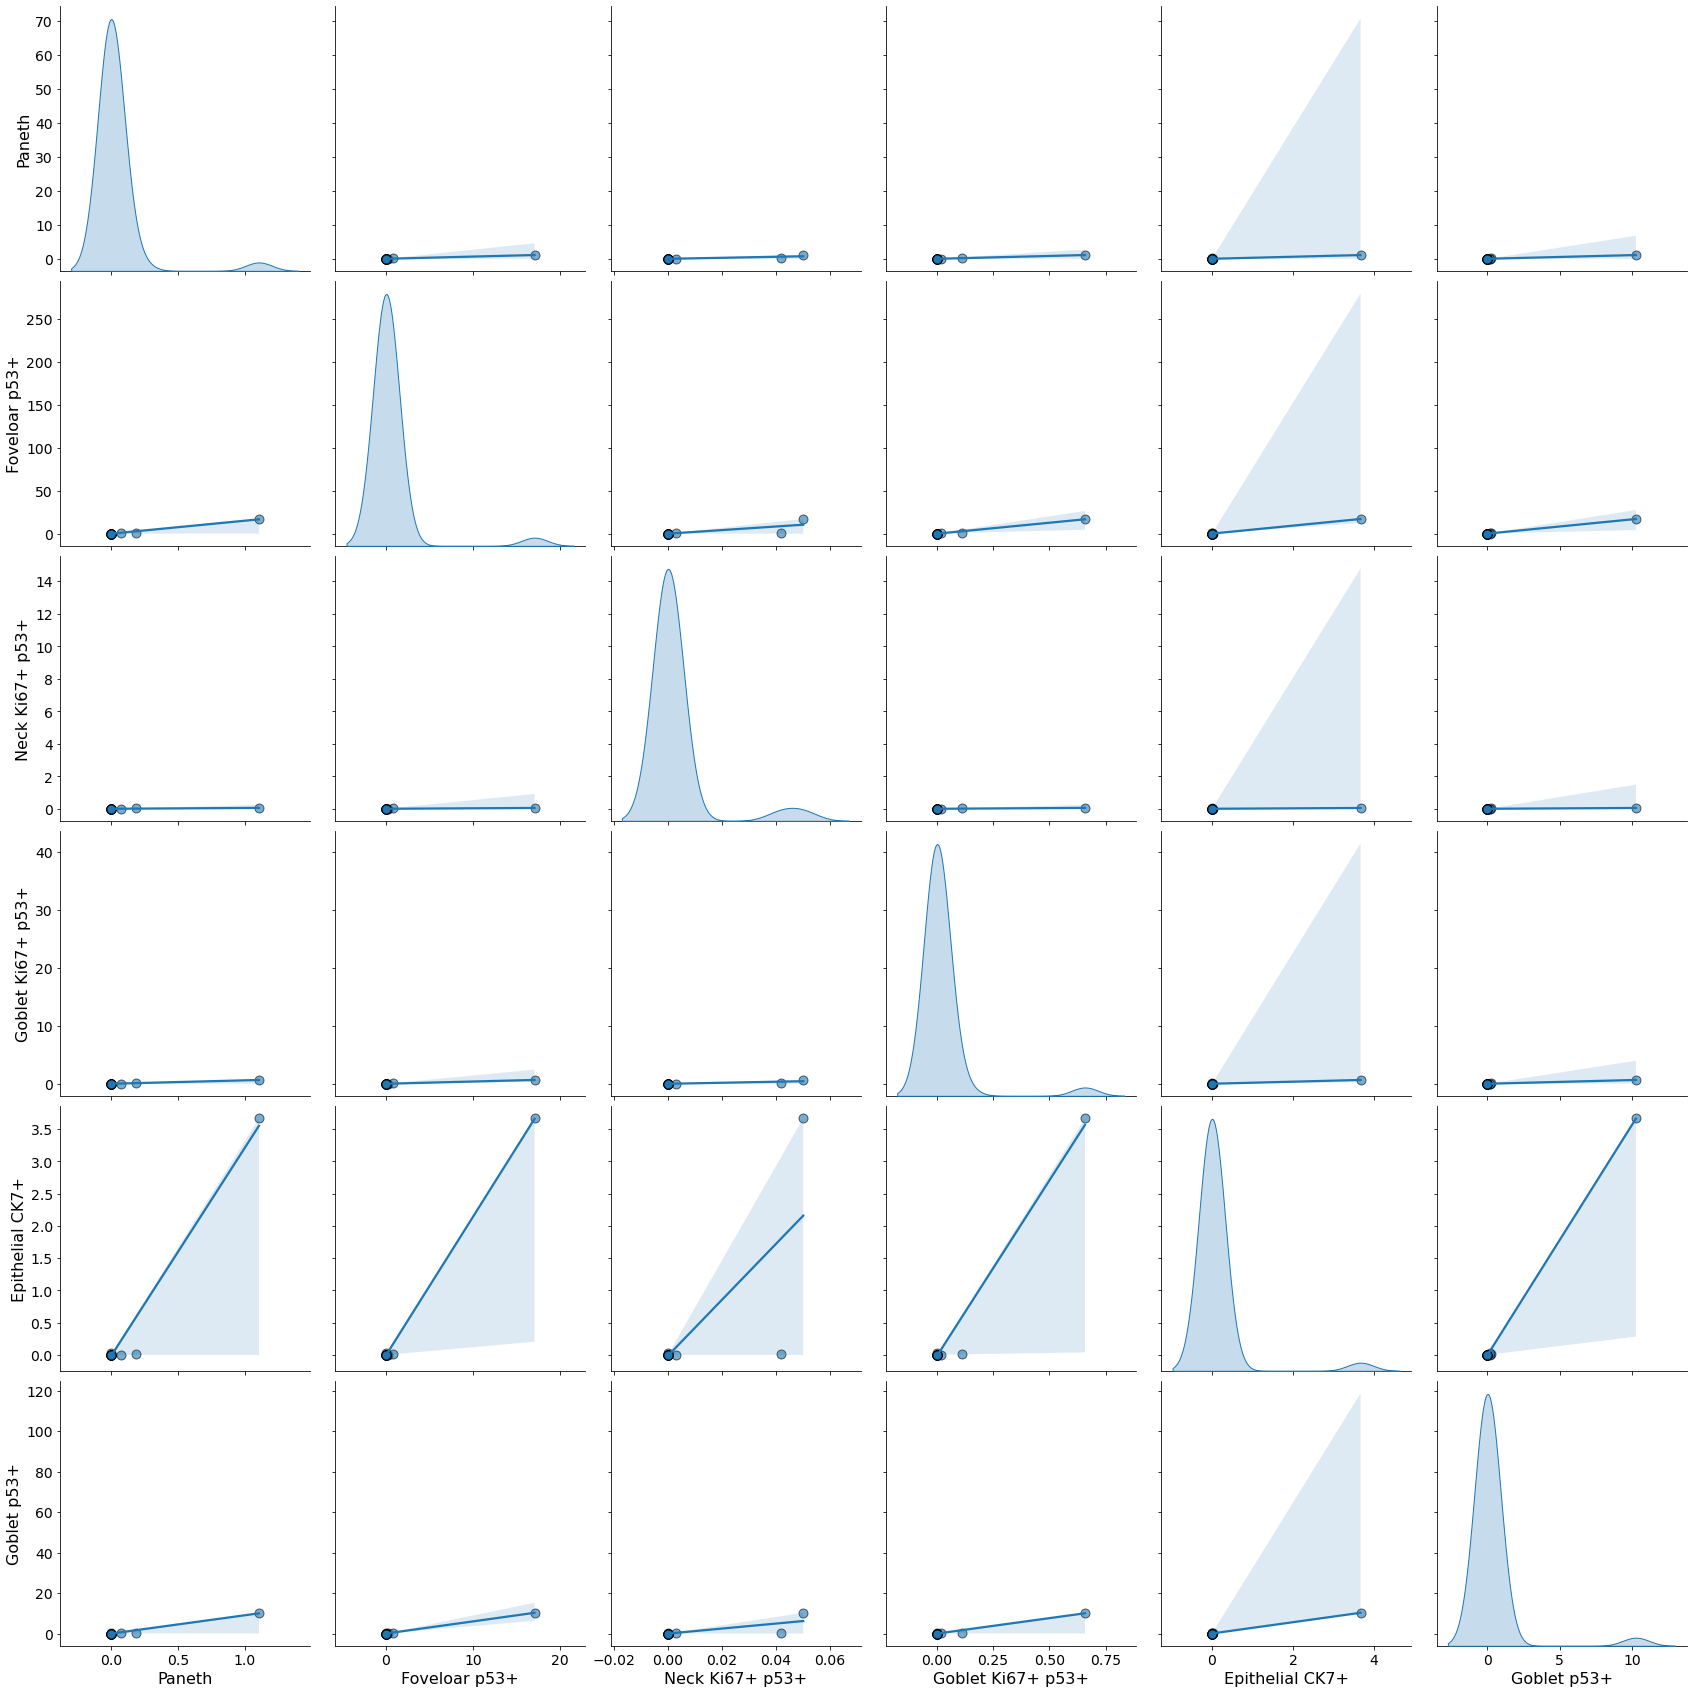

In [28]:
sl = pair_list
cor_subplot(mp=mp_cell, sub_list=sl)#, save_name='CK7')

In [ ]:
pairs = get_top_abs_correlations(cor_mat_neigh,thresh=0.5)
pairs

In [ ]:
piar = pairs.loc[pairs['col1']=='Plasma cell enriched']
piar

In [ ]:
pairs = get_top_abs_correlations(cor_mat3,thresh=0.5)
pairs

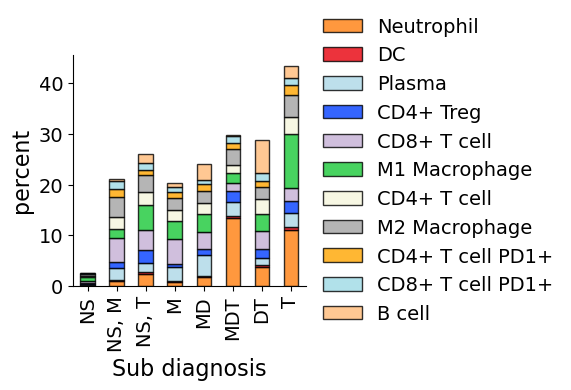

In [83]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Immune']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Cell Type', grouping = 'Sub diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(3,3), name_cat ='Cell Type',  \
                    col_order=sub_order,save_name='Imm_Cell_Subconsensus',pal_color=cell_map)

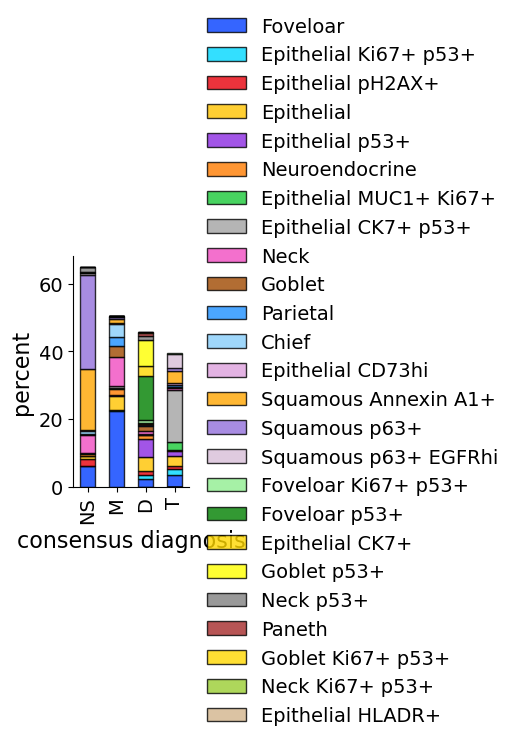

In [26]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Cell Type', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Cell Type',  \
                    col_order=con_order,save_name='Cell_Consensus',)

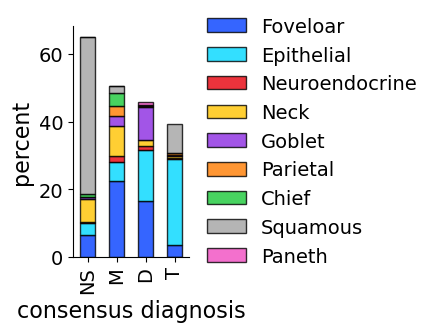

In [24]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'consensus diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(1.5,3), name_cat ='Coarse Cell',  \
                    col_order=con_order,save_name='Coarse_Consensus',)

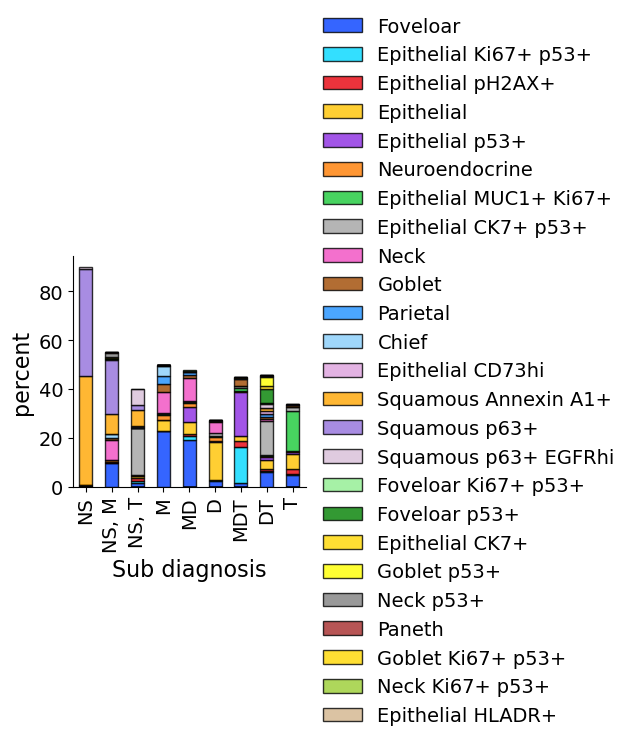

In [27]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Cell Type', grouping = 'Sub diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(3,3), name_cat ='Cell Type',  \
                    col_order=sub_order,save_name='Cell_subConsensus',)

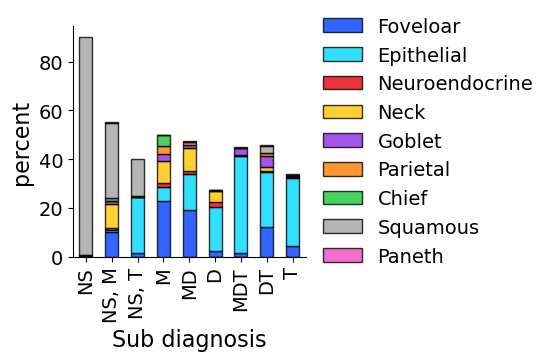

In [25]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'Sub diagnosis',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(3,3), name_cat ='Coarse Cell',  \
                    col_order=sub_order,save_name='Coarse_subConsensus',)

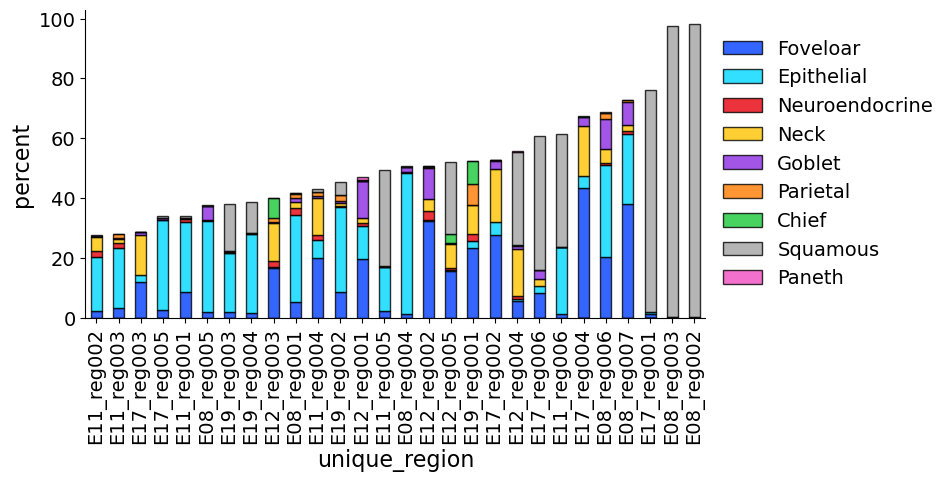

In [14]:
#Total
#col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

all_list = ['Epithelial']
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = 'Coarse Cell', grouping = 'unique_region',sub_col='Major Cell Cat',\
          cell_list=all_list,norm=False,fig_sizing=(8,4), name_cat ='Coarse Cell',  \
                    ) #h_order=h_ordertu, col_order=order_tis , save_name='M1_M2_tu',pal_color=col_map

In [ ]:
sub_list = ['Immune']
total_neigh_st = swarm_box(data=df, grouping='Tissue Unit', replicate='donor',sub_col='Cell subtype',\
                   sub_list=sub_list, norm=True, per_cat= 'Cell Type', figure_sizing=(5,5), save_name='me_stromal_cell')

In [ ]:
sub_list = ['Immune']
total_neigh_im= swarm_box(data=df, grouping='tissue', replicate='donor',sub_col='Cell subtype',\
                   sub_list=sub_list, norm=True, per_cat= 'Cell Type', figure_sizing=(8,5), save_name='Immune_cell')

tt = area_plot(data = df, per_cat = 'Cell Type', grouping = 'Tissue_location',col_order=tissue_order,\
          cell_list=sub_list, sub_col = 'Cell subtype', fig_sizing=(6.5,4), norm=True, color_dict=cell_map,\
              save_name='Immune_cell')

In [ ]:
#Total
col_map = {'Mucosa':'lightgreen', 'Muscularis mucosa':'orange', 'Submucosa':'gray', 'Muscularis externa':'red'}

Sub_df = df.loc[df['Cell Type'].isin(['M1 Macrophage', 'M2 Macrophage'])]
all_list = list(Sub_df['Tissue Unit'].unique())
order_tis = ['M1 Macrophage', 'M2 Macrophage']
h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = Sub_df, per_cat = 'Tissue Unit', grouping = 'Cell Type',sub_col='Tissue Unit',\
          cell_list=all_list,norm=False,fig_sizing=(2,4), name_cat ='Tissue Unit',  \
                   h_order=h_ordertu, col_order=order_tis , save_name='M1_M2_tu', pal_color=col_map)